In [ ]:
import pandas as pd
PATH = "Input path to csv file of Index"

In [ ]:
import pandas as pd
df = pd.read_csv(PATH,parse_dates=["Date"],index_col = ['Date'])
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [ ]:
stock_prices = pd.DataFrame(df["Close"]).rename(columns = {"Close":"Price"})
stock_prices.head()

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


In [ ]:
timesteps = stock_prices.index.to_numpy()
prices = stock_prices["Price"].to_numpy()
timesteps[:10], prices[:10]

(array(['2014-09-17T00:00:00.000000000', '2014-09-18T00:00:00.000000000',
        '2014-09-19T00:00:00.000000000', '2014-09-20T00:00:00.000000000',
        '2014-09-21T00:00:00.000000000', '2014-09-22T00:00:00.000000000',
        '2014-09-23T00:00:00.000000000', '2014-09-24T00:00:00.000000000',
        '2014-09-25T00:00:00.000000000', '2014-09-26T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
        402.152008, 435.790985, 423.204987, 411.574005, 404.424988]))

Text(0.5, 0, 'Date')

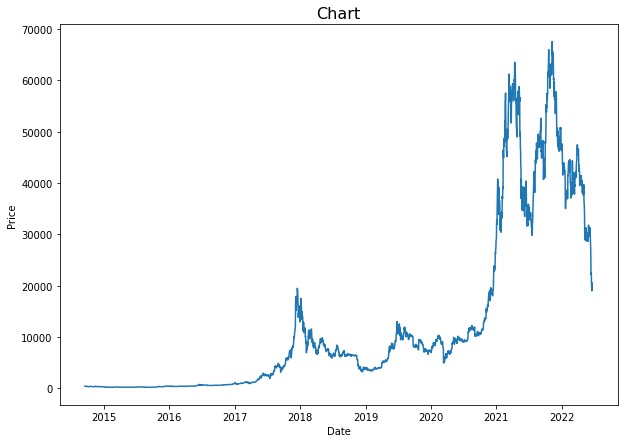

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.plot(timesteps, prices)
plt.ylabel("Price")
plt.title("Chart", fontsize = 16)
plt.xlabel('Date')

In [ ]:
split_size = int(0.8 * len(prices)) # 80% train, 20% test
X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]
len(X_train), len(X_test), len(y_train), len(y_test)

(2267, 567, 2267, 567)

In [ ]:
def plot_time_series(timesteps, values, format='.', start = 0, end = None, label = None):
  """
  Plots timesteps against values
  Parameters:
  ----------
  timesteps: array of timestep values
  values: array of values across time
  format: style of plot, default = "."
  start: where to start plot
  end: Where to end plot
  label: Label to show on plot about values
  """
  plt.plot(timesteps[start:end], values[start:end], format, label = label)
  plt.xlabel("Time")
  plt.ylabel("Price")
  if label:
    plt.legend(fontsize = 14)
  plt.grid(True)

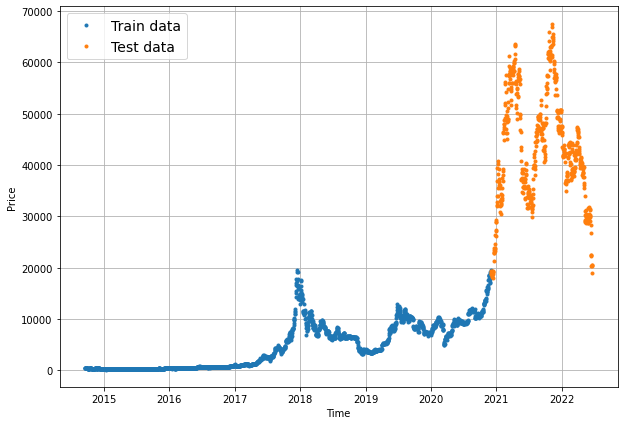

In [ ]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps = X_train,values = y_train, label = "Train data")
plot_time_series(timesteps=X_test, values = y_test, label = "Test data")

In [ ]:
naive_forecast = y_test[:-1]
naive_forecast[:10], naive_forecast[-10:]

(array([18802.998047, 19201.091797, 19445.398438, 18699.765625,
        19154.230469, 19345.121094, 19191.630859, 18321.144531,
        18553.916016, 18264.992188]),
 array([29083.804688, 28360.810547, 26762.648438, 22487.388672,
        22206.792969, 22572.839844, 20381.650391, 20471.482422,
        19017.642578, 20553.271484]))

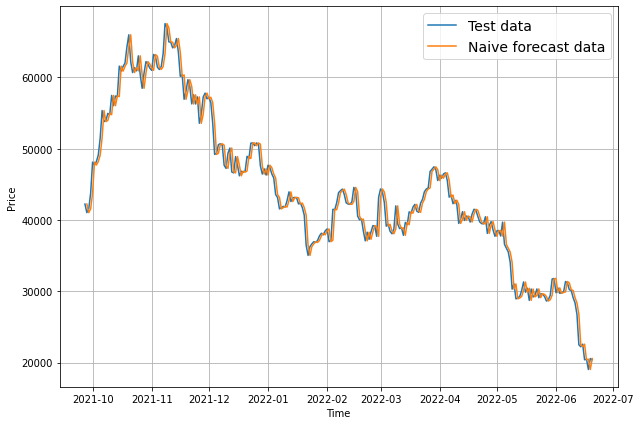

In [ ]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps = X_test, values = y_test,start = 300, format = '-', label = 'Test data')
plot_time_series(timesteps = X_test[1:], values = naive_forecast,start = 300 ,format = '-', label = 'Naive forecast data')

In [ ]:
import tensorflow as tf
def m_a_s_e(y_true, y_pred):
  """
  Implement MASE
  """
  mae  = tf.reduce_mean(tf.abs(y_true - y_pred))
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
  return mae/mae_naive_no_season

In [ ]:
def evaluate_pred(y_true, y_pred):
  y_true = tf.cast(y_true, dtype= tf.float32)
  y_pred = tf.cast(y_pred, dtype= tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = m_a_s_e(y_true, y_pred)

  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae" : mae.numpy(),
          "mse" : mse.numpy(),
          "rmse" : rmse.numpy(),
          "mape" : mape.numpy(),
          "mase" : mase.numpy()}

In [ ]:
naive_results = evaluate_pred(y_true=y_test[1:], y_pred=naive_forecast)
naive_results

{'mae': 1245.2593,
 'mape': 2.9662337,
 'mase': 0.99879736,
 'mse': 2924243.8,
 'rmse': 1710.042}

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

## Have to get the ```tf.keras.preprocessing.timeseries_dataset_from_array()``` working

In [ ]:
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [ ]:
# import tensorflow as tf
# import numpy as np

# dataset = tf.keras.preprocessing.timeseries_dataset_from_array(prices,targets = None,sequence_stride=1 ,sequence_length=8, shuffle = False)
# for batch in dataset:
#   inputs = batch
# print(len(dataset))

In [ ]:
import numpy as np
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T
  windowed_array = x[window_indexes]
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [ ]:
full_windows, full_labels = make_windows(prices, window_size = WINDOW_SIZE, horizon = HORIZON)
len(full_windows), len(full_labels)

(2827, 2827)

In [ ]:
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2261, 566, 2261, 566)

In [ ]:
import os

def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), verbose=0, save_best_only=True)

In [ ]:
# Making forecast function
def make_preds(model, input_data):
  '''
  Uses model to make predictions input_data
  '''
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

## Models 1-10

### Model 1: Dense Model (window = 7, horizon = 1)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(42)
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation = 'relu'),
  layers.Dense(HORIZON, activation = 'linear')
], name = 'model_1')

model_1.compile(loss = "mae", 
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['mae', 'mse'])

model_1.fit(x = train_windows,y = train_labels, 
            epochs = 100, 
            verbose = 1, 
            batch_size = 100, 
            validation_data = (test_windows, test_labels), 
            callbacks = [create_model_checkpoint(model_name = model_1.name)])

Epoch 1/100
14/23 [=================>............] - ETA: 0s - loss: 1227.4785 - mae: 1227.4785 - mse: 4433624.0000  INFO:tensorflow:Assets written to: model_experiments/model_1/assets


INFO:tensorflow:Assets written to: model_experiments/model_1/assets


23/23 [==============================] - 2s 50ms/step - loss: 940.2222 - mae: 940.2222 - mse: 2981929.5000 - val_loss: 2229.2144 - val_mae: 2229.2144 - val_mse: 8346776.0000
Epoch 2/100
23/23 [==============================] - 0s 8ms/step - loss: 277.1708 - mae: 277.1708 - mse: 277749.7188 - val_loss: 2299.9480 - val_mae: 2299.9480 - val_mse: 8577322.0000
Epoch 3/100
12/23 [==============>...............] - ETA: 0s - loss: 250.4052 - mae: 250.4052 - mse: 238151.3594INFO:tensorflow:Assets written to: model_experiments/model_1/assets


INFO:tensorflow:Assets written to: model_experiments/model_1/assets


23/23 [==============================] - 1s 48ms/step - loss: 238.1819 - mae: 238.1819 - mse: 220517.2812 - val_loss: 2071.9358 - val_mae: 2071.9358 - val_mse: 7274071.5000
Epoch 4/100
22/23 [===========================>..] - ETA: 0s - loss: 221.8184 - mae: 221.8184 - mse: 201094.4219INFO:tensorflow:Assets written to: model_experiments/model_1/assets


INFO:tensorflow:Assets written to: model_experiments/model_1/assets


23/23 [==============================] - 1s 48ms/step - loss: 219.2256 - mae: 219.2256 - mse: 197222.0000 - val_loss: 1970.7792 - val_mae: 1970.7792 - val_mse: 6523300.5000
Epoch 5/100
21/23 [==========================>...] - ETA: 0s - loss: 214.1218 - mae: 214.1218 - mse: 187732.8438INFO:tensorflow:Assets written to: model_experiments/model_1/assets


INFO:tensorflow:Assets written to: model_experiments/model_1/assets


23/23 [==============================] - 1s 44ms/step - loss: 215.0743 - mae: 215.0743 - mse: 189036.5938 - val_loss: 1912.6029 - val_mae: 1912.6029 - val_mse: 6147602.5000
Epoch 6/100
21/23 [==========================>...] - ETA: 0s - loss: 204.2284 - mae: 204.2284 - mse: 175353.3125INFO:tensorflow:Assets written to: model_experiments/model_1/assets


INFO:tensorflow:Assets written to: model_experiments/model_1/assets


23/23 [==============================] - 1s 46ms/step - loss: 204.6485 - mae: 204.6485 - mse: 174618.5156 - val_loss: 1838.5159 - val_mae: 1838.5159 - val_mse: 5691097.5000
Epoch 7/100
22/23 [===========================>..] - ETA: 0s - loss: 191.4623 - mae: 191.4623 - mse: 158724.7969INFO:tensorflow:Assets written to: model_experiments/model_1/assets


INFO:tensorflow:Assets written to: model_experiments/model_1/assets


23/23 [==============================] - 1s 46ms/step - loss: 191.6141 - mae: 191.6141 - mse: 158286.0156 - val_loss: 1763.9604 - val_mae: 1763.9604 - val_mse: 5204445.0000
Epoch 8/100
21/23 [==========================>...] - ETA: 0s - loss: 189.1500 - mae: 189.1500 - mse: 145854.7031INFO:tensorflow:Assets written to: model_experiments/model_1/assets


INFO:tensorflow:Assets written to: model_experiments/model_1/assets


23/23 [==============================] - 1s 57ms/step - loss: 191.7873 - mae: 191.7873 - mse: 153139.6250 - val_loss: 1734.3721 - val_mae: 1734.3718 - val_mse: 5119362.5000
Epoch 9/100
19/23 [=======================>......] - ETA: 0s - loss: 180.7209 - mae: 180.7209 - mse: 144928.8750INFO:tensorflow:Assets written to: model_experiments/model_1/assets


INFO:tensorflow:Assets written to: model_experiments/model_1/assets


23/23 [==============================] - 1s 53ms/step - loss: 179.6155 - mae: 179.6155 - mse: 139951.1562 - val_loss: 1625.0020 - val_mae: 1625.0020 - val_mse: 4433682.0000
Epoch 10/100
23/23 [==============================] - 0s 8ms/step - loss: 172.0494 - mae: 172.0494 - mse: 129146.3125 - val_loss: 1663.0731 - val_mae: 1663.0731 - val_mse: 4798338.5000
Epoch 11/100
21/23 [==========================>...] - ETA: 0s - loss: 167.0300 - mae: 167.0300 - mse: 124457.8047INFO:tensorflow:Assets written to: model_experiments/model_1/assets


INFO:tensorflow:Assets written to: model_experiments/model_1/assets


23/23 [==============================] - 1s 61ms/step - loss: 169.0248 - mae: 169.0248 - mse: 127094.0234 - val_loss: 1537.0853 - val_mae: 1537.0853 - val_mse: 4029912.2500
Epoch 12/100
14/23 [=================>............] - ETA: 0s - loss: 169.2502 - mae: 169.2502 - mse: 131904.9219INFO:tensorflow:Assets written to: model_experiments/model_1/assets


INFO:tensorflow:Assets written to: model_experiments/model_1/assets


23/23 [==============================] - 1s 55ms/step - loss: 161.7474 - mae: 161.7474 - mse: 119132.3359 - val_loss: 1501.2301 - val_mae: 1501.2301 - val_mse: 3903109.0000
Epoch 13/100
23/23 [==============================] - 0s 13ms/step - loss: 163.6541 - mae: 163.6541 - mse: 119656.2656 - val_loss: 1536.7665 - val_mae: 1536.7665 - val_mse: 4165743.7500
Epoch 14/100
17/23 [=====================>........] - ETA: 0s - loss: 158.5420 - mae: 158.5420 - mse: 117135.3281INFO:tensorflow:Assets written to: model_experiments/model_1/assets


INFO:tensorflow:Assets written to: model_experiments/model_1/assets


23/23 [==============================] - 1s 42ms/step - loss: 160.3861 - mae: 160.3861 - mse: 115084.2734 - val_loss: 1452.8169 - val_mae: 1452.8169 - val_mse: 3714267.2500
Epoch 15/100
20/23 [=========================>....] - ETA: 0s - loss: 156.2529 - mae: 156.2529 - mse: 114984.0234INFO:tensorflow:Assets written to: model_experiments/model_1/assets


INFO:tensorflow:Assets written to: model_experiments/model_1/assets


23/23 [==============================] - 1s 49ms/step - loss: 154.4576 - mae: 154.4576 - mse: 110970.5547 - val_loss: 1447.9404 - val_mae: 1447.9404 - val_mse: 3734602.2500
Epoch 16/100
18/23 [======================>.......] - ETA: 0s - loss: 158.2475 - mae: 158.2475 - mse: 113498.5156INFO:tensorflow:Assets written to: model_experiments/model_1/assets


INFO:tensorflow:Assets written to: model_experiments/model_1/assets


23/23 [==============================] - 1s 59ms/step - loss: 155.4675 - mae: 155.4675 - mse: 109540.4844 - val_loss: 1422.4292 - val_mae: 1422.4292 - val_mse: 3612303.5000
Epoch 17/100
23/23 [==============================] - 0s 10ms/step - loss: 152.1719 - mae: 152.1719 - mse: 106323.9531 - val_loss: 1429.1716 - val_mae: 1429.1715 - val_mse: 3659470.5000
Epoch 18/100
12/23 [==============>...............] - ETA: 0s - loss: 163.2983 - mae: 163.2983 - mse: 122415.2969INFO:tensorflow:Assets written to: model_experiments/model_1/assets


INFO:tensorflow:Assets written to: model_experiments/model_1/assets


23/23 [==============================] - 1s 36ms/step - loss: 157.6667 - mae: 157.6667 - mse: 110738.1016 - val_loss: 1390.9073 - val_mae: 1390.9073 - val_mse: 3424309.2500
Epoch 19/100
23/23 [==============================] - 0s 7ms/step - loss: 151.9252 - mae: 151.9252 - mse: 105296.4141 - val_loss: 1393.1001 - val_mae: 1393.1001 - val_mse: 3497464.0000
Epoch 20/100
13/23 [===============>..............] - ETA: 0s - loss: 141.8230 - mae: 141.8230 - mse: 105062.5078INFO:tensorflow:Assets written to: model_experiments/model_1/assets


INFO:tensorflow:Assets written to: model_experiments/model_1/assets


23/23 [==============================] - 2s 71ms/step - loss: 146.9299 - mae: 146.9299 - mse: 102322.0469 - val_loss: 1371.7083 - val_mae: 1371.7083 - val_mse: 3366236.2500
Epoch 21/100
11/23 [=============>................] - ETA: 0s - loss: 140.7782 - mae: 140.7782 - mse: 89397.9531INFO:tensorflow:Assets written to: model_experiments/model_1/assets


INFO:tensorflow:Assets written to: model_experiments/model_1/assets


23/23 [==============================] - 1s 44ms/step - loss: 147.2371 - mae: 147.2371 - mse: 101370.5781 - val_loss: 1365.0956 - val_mae: 1365.0956 - val_mse: 3338300.5000
Epoch 22/100
23/23 [==============================] - 0s 7ms/step - loss: 149.6252 - mae: 149.6252 - mse: 102455.2578 - val_loss: 1376.3973 - val_mae: 1376.3973 - val_mse: 3333213.2500
Epoch 23/100
22/23 [===========================>..] - ETA: 0s - loss: 149.8748 - mae: 149.8748 - mse: 102587.1406INFO:tensorflow:Assets written to: model_experiments/model_1/assets


INFO:tensorflow:Assets written to: model_experiments/model_1/assets


23/23 [==============================] - 1s 48ms/step - loss: 148.9267 - mae: 148.9267 - mse: 101203.9609 - val_loss: 1352.1963 - val_mae: 1352.1963 - val_mse: 3307597.7500
Epoch 24/100
23/23 [==============================] - 0s 7ms/step - loss: 146.1140 - mae: 146.1140 - mse: 98640.8516 - val_loss: 1394.2742 - val_mae: 1394.2742 - val_mse: 3368201.5000
Epoch 25/100
16/23 [===================>..........] - ETA: 0s - loss: 151.2930 - mae: 151.2930 - mse: 105711.6172INFO:tensorflow:Assets written to: model_experiments/model_1/assets


INFO:tensorflow:Assets written to: model_experiments/model_1/assets


23/23 [==============================] - 1s 42ms/step - loss: 145.9997 - mae: 145.9997 - mse: 99051.0078 - val_loss: 1341.4460 - val_mae: 1341.4460 - val_mse: 3272089.2500
Epoch 26/100
23/23 [==============================] - 0s 7ms/step - loss: 144.2760 - mae: 144.2760 - mse: 97901.1406 - val_loss: 1376.0123 - val_mae: 1376.0123 - val_mse: 3447414.7500
Epoch 27/100
14/23 [=================>............] - ETA: 0s - loss: 141.1023 - mae: 141.1023 - mse: 92095.7969INFO:tensorflow:Assets written to: model_experiments/model_1/assets


INFO:tensorflow:Assets written to: model_experiments/model_1/assets


23/23 [==============================] - 1s 35ms/step - loss: 143.8135 - mae: 143.8135 - mse: 98267.8828 - val_loss: 1332.3981 - val_mae: 1332.3981 - val_mse: 3227235.5000
Epoch 28/100
23/23 [==============================] - 0s 7ms/step - loss: 145.2116 - mae: 145.2116 - mse: 98305.7656 - val_loss: 1334.2611 - val_mae: 1334.2611 - val_mse: 3270985.2500
Epoch 29/100
13/23 [===============>..............] - ETA: 0s - loss: 136.8025 - mae: 136.8025 - mse: 85531.0156INFO:tensorflow:Assets written to: model_experiments/model_1/assets


INFO:tensorflow:Assets written to: model_experiments/model_1/assets


23/23 [==============================] - 1s 38ms/step - loss: 141.8149 - mae: 141.8149 - mse: 96125.7812 - val_loss: 1323.4769 - val_mae: 1323.4769 - val_mse: 3193643.2500
Epoch 30/100
23/23 [==============================] - 0s 9ms/step - loss: 143.2516 - mae: 143.2516 - mse: 96944.2656 - val_loss: 1468.7040 - val_mae: 1468.7040 - val_mse: 3798091.0000
Epoch 31/100
23/23 [==============================] - 0s 4ms/step - loss: 145.9275 - mae: 145.9274 - mse: 97757.9375 - val_loss: 1332.0708 - val_mae: 1332.0708 - val_mse: 3183651.0000
Epoch 32/100
23/23 [==============================] - 0s 4ms/step - loss: 155.3053 - mae: 155.3053 - mse: 103878.5859 - val_loss: 1368.8109 - val_mae: 1368.8109 - val_mse: 3278865.0000
Epoch 33/100
23/23 [==============================] - 0s 4ms/step - loss: 153.4722 - mae: 153.4722 - mse: 102534.1406 - val_loss: 1433.2495 - val_mae: 1433.2495 - val_mse: 3498812.2500
Epoch 34/100
20/23 [=========================>....] - ETA: 0s - loss: 151.3953 - mae: 151.

INFO:tensorflow:Assets written to: model_experiments/model_1/assets


23/23 [==============================] - 0s 22ms/step - loss: 147.0037 - mae: 147.0037 - mse: 101809.7578 - val_loss: 1306.0353 - val_mae: 1306.0353 - val_mse: 3143777.2500
Epoch 35/100
20/23 [=========================>....] - ETA: 0s - loss: 141.7218 - mae: 141.7218 - mse: 93633.8203INFO:tensorflow:Assets written to: model_experiments/model_1/assets


INFO:tensorflow:Assets written to: model_experiments/model_1/assets


23/23 [==============================] - 0s 22ms/step - loss: 144.1076 - mae: 144.1076 - mse: 96514.8203 - val_loss: 1305.1370 - val_mae: 1305.1370 - val_mse: 3132784.5000
Epoch 36/100
23/23 [==============================] - 0s 4ms/step - loss: 140.9917 - mae: 140.9917 - mse: 94140.4453 - val_loss: 1440.2095 - val_mae: 1440.2095 - val_mse: 3526627.5000
Epoch 37/100
23/23 [==============================] - 0s 5ms/step - loss: 150.1818 - mae: 150.1818 - mse: 99898.7656 - val_loss: 1311.9659 - val_mae: 1311.9659 - val_mse: 3128894.0000
Epoch 38/100
23/23 [==============================] - 0s 4ms/step - loss: 142.9901 - mae: 142.9901 - mse: 95601.6641 - val_loss: 1476.9303 - val_mae: 1476.9303 - val_mse: 3671134.2500
Epoch 39/100
23/23 [==============================] - 0s 4ms/step - loss: 144.6763 - mae: 144.6763 - mse: 96323.6875 - val_loss: 1316.9172 - val_mae: 1316.9172 - val_mse: 3128911.5000
Epoch 40/100
22/23 [===========================>..] - ETA: 0s - loss: 140.1802 - mae: 140.18

INFO:tensorflow:Assets written to: model_experiments/model_1/assets


23/23 [==============================] - 0s 21ms/step - loss: 138.5404 - mae: 138.5404 - mse: 92087.5469 - val_loss: 1300.5160 - val_mae: 1300.5160 - val_mse: 3154102.0000
Epoch 41/100
23/23 [==============================] - 0s 4ms/step - loss: 139.8191 - mae: 139.8191 - mse: 92310.4844 - val_loss: 1434.0232 - val_mae: 1434.0232 - val_mse: 3642547.0000
Epoch 42/100
23/23 [==============================] - 0s 4ms/step - loss: 139.3451 - mae: 139.3451 - mse: 91625.0859 - val_loss: 1399.1294 - val_mae: 1399.1294 - val_mse: 3510149.5000
Epoch 43/100
21/23 [==========================>...] - ETA: 0s - loss: 144.0999 - mae: 144.0999 - mse: 95538.6406INFO:tensorflow:Assets written to: model_experiments/model_1/assets


INFO:tensorflow:Assets written to: model_experiments/model_1/assets


23/23 [==============================] - 0s 20ms/step - loss: 143.4077 - mae: 143.4077 - mse: 93595.6875 - val_loss: 1294.6111 - val_mae: 1294.6111 - val_mse: 3134514.7500
Epoch 44/100
21/23 [==========================>...] - ETA: 0s - loss: 147.0971 - mae: 147.0971 - mse: 99140.0234INFO:tensorflow:Assets written to: model_experiments/model_1/assets


INFO:tensorflow:Assets written to: model_experiments/model_1/assets


23/23 [==============================] - 0s 21ms/step - loss: 146.7040 - mae: 146.7040 - mse: 98008.2031 - val_loss: 1287.1322 - val_mae: 1287.1322 - val_mse: 3076497.0000
Epoch 45/100
23/23 [==============================] - 0s 5ms/step - loss: 149.2489 - mae: 149.2489 - mse: 94620.7422 - val_loss: 1318.1101 - val_mae: 1318.1101 - val_mse: 3219578.0000
Epoch 46/100
23/23 [==============================] - 0s 4ms/step - loss: 139.6474 - mae: 139.6474 - mse: 91815.1016 - val_loss: 1297.5964 - val_mae: 1297.5963 - val_mse: 3077538.0000
Epoch 47/100
23/23 [==============================] - 0s 5ms/step - loss: 139.1042 - mae: 139.1042 - mse: 91296.7969 - val_loss: 1289.9238 - val_mae: 1289.9238 - val_mse: 3118255.7500
Epoch 48/100
23/23 [==============================] - 0s 4ms/step - loss: 138.0310 - mae: 138.0310 - mse: 90673.6406 - val_loss: 1349.7025 - val_mae: 1349.7025 - val_mse: 3214422.7500
Epoch 49/100
23/23 [==============================] - 0s 4ms/step - loss: 138.1603 - mae: 13

INFO:tensorflow:Assets written to: model_experiments/model_1/assets


23/23 [==============================] - 0s 21ms/step - loss: 147.1597 - mae: 147.1597 - mse: 96907.0469 - val_loss: 1278.1251 - val_mae: 1278.1251 - val_mse: 3045700.5000
Epoch 51/100
23/23 [==============================] - 0s 4ms/step - loss: 150.7811 - mae: 150.7811 - mse: 95543.5156 - val_loss: 1293.2645 - val_mae: 1293.2645 - val_mse: 3061719.0000
Epoch 52/100
23/23 [==============================] - 0s 4ms/step - loss: 148.6893 - mae: 148.6893 - mse: 94890.1953 - val_loss: 1402.4088 - val_mae: 1402.4086 - val_mse: 3513711.0000
Epoch 53/100
23/23 [==============================] - 0s 5ms/step - loss: 147.7238 - mae: 147.7238 - mse: 97598.7031 - val_loss: 1301.9166 - val_mae: 1301.9166 - val_mse: 3077783.5000
Epoch 54/100
23/23 [==============================] - 0s 4ms/step - loss: 136.6358 - mae: 136.6358 - mse: 89992.6641 - val_loss: 1288.6139 - val_mae: 1288.6139 - val_mse: 3049884.5000
Epoch 55/100
23/23 [==============================] - 0s 4ms/step - loss: 139.0473 - mae: 13

INFO:tensorflow:Assets written to: model_experiments/model_1/assets


23/23 [==============================] - 0s 21ms/step - loss: 143.0226 - mae: 143.0226 - mse: 91517.4297 - val_loss: 1273.1276 - val_mae: 1273.1276 - val_mse: 3027015.7500
Epoch 57/100
23/23 [==============================] - 0s 4ms/step - loss: 138.5800 - mae: 138.5800 - mse: 90560.0000 - val_loss: 1366.3599 - val_mae: 1366.3599 - val_mse: 3379358.7500
Epoch 58/100
23/23 [==============================] - 0s 5ms/step - loss: 139.8548 - mae: 139.8548 - mse: 91541.8203 - val_loss: 1308.0414 - val_mae: 1308.0414 - val_mse: 3176269.0000
Epoch 59/100
23/23 [==============================] - 0s 4ms/step - loss: 135.9467 - mae: 135.9467 - mse: 89170.0312 - val_loss: 1279.3779 - val_mae: 1279.3779 - val_mse: 3078738.0000
Epoch 60/100
23/23 [==============================] - 0s 4ms/step - loss: 141.6360 - mae: 141.6360 - mse: 90435.7500 - val_loss: 1313.7931 - val_mae: 1313.7931 - val_mse: 3108957.7500
Epoch 61/100
21/23 [==========================>...] - ETA: 0s - loss: 139.4720 - mae: 139.47

INFO:tensorflow:Assets written to: model_experiments/model_1/assets


23/23 [==============================] - 0s 21ms/step - loss: 139.4373 - mae: 139.4373 - mse: 91748.1172 - val_loss: 1267.9445 - val_mae: 1267.9445 - val_mse: 3011987.7500
Epoch 62/100
23/23 [==============================] - 0s 4ms/step - loss: 142.4844 - mae: 142.4844 - mse: 92641.6953 - val_loss: 1408.1639 - val_mae: 1408.1639 - val_mse: 3529677.0000
Epoch 63/100
23/23 [==============================] - 0s 4ms/step - loss: 146.7453 - mae: 146.7453 - mse: 93832.0625 - val_loss: 1304.2401 - val_mae: 1304.2401 - val_mse: 3160152.2500
Epoch 64/100
23/23 [==============================] - 0s 4ms/step - loss: 141.5374 - mae: 141.5374 - mse: 91898.9453 - val_loss: 1290.2153 - val_mae: 1290.2153 - val_mse: 3044569.0000
Epoch 65/100
23/23 [==============================] - 0s 4ms/step - loss: 138.9938 - mae: 138.9938 - mse: 89907.0312 - val_loss: 1335.0409 - val_mae: 1335.0409 - val_mse: 3173528.0000
Epoch 66/100
23/23 [==============================] - 0s 5ms/step - loss: 141.5260 - mae: 14

INFO:tensorflow:Assets written to: model_experiments/model_1/assets


23/23 [==============================] - 0s 21ms/step - loss: 143.7582 - mae: 143.7582 - mse: 92103.6953 - val_loss: 1259.4994 - val_mae: 1259.4994 - val_mse: 2997974.7500
Epoch 75/100
23/23 [==============================] - 0s 4ms/step - loss: 134.6522 - mae: 134.6522 - mse: 87639.3750 - val_loss: 1274.5320 - val_mae: 1274.5320 - val_mse: 3060611.7500
Epoch 76/100
23/23 [==============================] - 0s 4ms/step - loss: 134.9317 - mae: 134.9317 - mse: 87064.5625 - val_loss: 1277.7141 - val_mae: 1277.7141 - val_mse: 3015898.0000
Epoch 77/100
23/23 [==============================] - 0s 4ms/step - loss: 138.5652 - mae: 138.5652 - mse: 88194.0156 - val_loss: 1335.4097 - val_mae: 1335.4097 - val_mse: 3175092.0000
Epoch 78/100
23/23 [==============================] - 0s 5ms/step - loss: 145.1709 - mae: 145.1709 - mse: 92485.2344 - val_loss: 1383.9319 - val_mae: 1383.9319 - val_mse: 3334471.0000
Epoch 79/100
23/23 [==============================] - 0s 4ms/step - loss: 142.4453 - mae: 14

INFO:tensorflow:Assets written to: model_experiments/model_1/assets


23/23 [==============================] - 0s 21ms/step - loss: 141.9206 - mae: 141.9206 - mse: 91250.4453 - val_loss: 1259.4542 - val_mae: 1259.4542 - val_mse: 2981456.7500
Epoch 83/100
23/23 [==============================] - 0s 4ms/step - loss: 133.8604 - mae: 133.8604 - mse: 86550.9609 - val_loss: 1259.8138 - val_mae: 1259.8138 - val_mse: 2999694.2500
Epoch 84/100
23/23 [==============================] - 0s 4ms/step - loss: 138.6226 - mae: 138.6226 - mse: 90849.9062 - val_loss: 1359.5184 - val_mae: 1359.5184 - val_mse: 3253438.2500
Epoch 85/100
17/23 [=====================>........] - ETA: 0s - loss: 136.8511 - mae: 136.8511 - mse: 91426.3438INFO:tensorflow:Assets written to: model_experiments/model_1/assets


INFO:tensorflow:Assets written to: model_experiments/model_1/assets


23/23 [==============================] - 0s 21ms/step - loss: 136.7860 - mae: 136.7860 - mse: 88125.7734 - val_loss: 1255.3903 - val_mae: 1255.3903 - val_mse: 2978559.7500
Epoch 86/100
23/23 [==============================] - 0s 4ms/step - loss: 133.8150 - mae: 133.8150 - mse: 86838.3203 - val_loss: 1319.9534 - val_mae: 1319.9534 - val_mse: 3208429.5000
Epoch 87/100
23/23 [==============================] - 0s 4ms/step - loss: 135.5559 - mae: 135.5560 - mse: 87575.8203 - val_loss: 1375.1663 - val_mae: 1375.1663 - val_mse: 3403824.7500
Epoch 88/100
23/23 [==============================] - 0s 4ms/step - loss: 136.3356 - mae: 136.3356 - mse: 88290.4688 - val_loss: 1261.1090 - val_mae: 1261.1090 - val_mse: 2975270.0000
Epoch 89/100
23/23 [==============================] - 0s 4ms/step - loss: 136.8569 - mae: 136.8569 - mse: 88203.3828 - val_loss: 1275.4531 - val_mae: 1275.4531 - val_mse: 3058265.2500
Epoch 90/100
23/23 [==============================] - 0s 4ms/step - loss: 138.1649 - mae: 13

INFO:tensorflow:Assets written to: model_experiments/model_1/assets


23/23 [==============================] - 0s 22ms/step - loss: 134.2634 - mae: 134.2634 - mse: 86972.2188 - val_loss: 1251.7927 - val_mae: 1251.7927 - val_mse: 2964340.2500
Epoch 100/100
23/23 [==============================] - 0s 4ms/step - loss: 135.2841 - mae: 135.2841 - mse: 87873.2031 - val_loss: 1285.6764 - val_mae: 1285.6764 - val_mse: 3028592.0000


In [ ]:
model_1 = tf.keras.models.load_model('/content/model_experiments/model_1')
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1251.7927 - mae: 1251.7927 - mse: 2964340.0000


[1251.792724609375, 1251.792724609375, 2964340.0]

In [ ]:
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

(566, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([19009.38 , 19201.975, 19418.12 , 18914.287, 19009.639, 19365.912,
        19261.484, 18388.383, 18534.62 , 18306.137], dtype=float32)>)

In [ ]:
model_1_results = evaluate_pred(y_true = tf.squeeze(test_labels), y_pred = model_1_preds)
model_1_results

{'mae': 1251.7927,
 'mape': 2.9839077,
 'mase': 1.0040377,
 'mse': 2964340.0,
 'rmse': 1721.7258}

In [ ]:
naive_results

{'mae': 1245.2593,
 'mape': 2.9662337,
 'mase': 0.99879736,
 'mse': 2924243.8,
 'rmse': 1710.042}

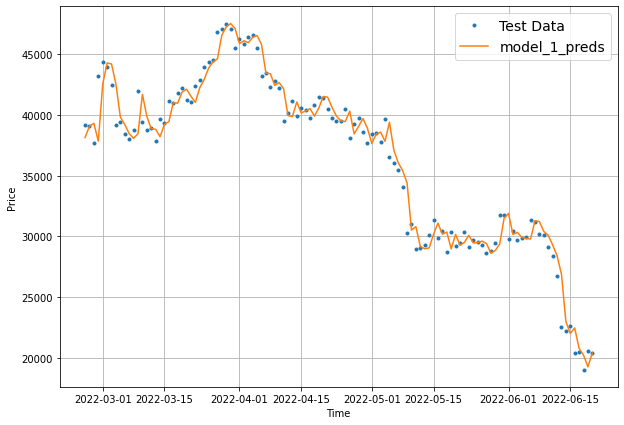

In [ ]:
offset = 450
plt.figure(figsize=(10,7))
plot_time_series(timesteps = X_test[-len(test_windows):], values = test_labels[:, 0], start = offset, label = "Test Data")
plot_time_series(timesteps = X_test[-len(test_windows):], values = model_1_preds, start = offset, format = '-', label = 'model_1_preds')

### Model 2: Dense Model (window = 30, horizon = 1)

In [ ]:
WINDOW_SIZE = 30
HORIZON = 1
full_windows, full_labels = make_windows(prices, window_size = WINDOW_SIZE, horizon = HORIZON)
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(42)
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation = 'relu'),
  layers.Dense(HORIZON, activation = 'linear')
], name = 'model_2')

model_2.compile(loss = "mae", 
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['mae', 'mse'])

model_2.fit(x = train_windows,y = train_labels, 
            epochs = 100, 
            verbose = 1, 
            batch_size = 100, 
            validation_data = (test_windows, test_labels), 
            callbacks = [create_model_checkpoint(model_name = model_2.name)])

Epoch 1/100
20/23 [=========================>....] - ETA: 0s - loss: 1351.8380 - mae: 1351.8380 - mse: 6231781.5000 INFO:tensorflow:Assets written to: model_experiments/model_2/assets


INFO:tensorflow:Assets written to: model_experiments/model_2/assets


23/23 [==============================] - 1s 40ms/step - loss: 1270.9738 - mae: 1270.9738 - mse: 5702197.5000 - val_loss: 5809.7002 - val_mae: 5809.7002 - val_mse: 51575140.0000
Epoch 2/100
19/23 [=======================>......] - ETA: 0s - loss: 476.2273 - mae: 476.2273 - mse: 781229.6250INFO:tensorflow:Assets written to: model_experiments/model_2/assets


INFO:tensorflow:Assets written to: model_experiments/model_2/assets


23/23 [==============================] - 0s 21ms/step - loss: 457.5442 - mae: 457.5442 - mse: 734457.7500 - val_loss: 2874.1519 - val_mae: 2874.1519 - val_mse: 12972859.0000
Epoch 3/100
16/23 [===================>..........] - ETA: 0s - loss: 301.4420 - mae: 301.4420 - mse: 357547.6875INFO:tensorflow:Assets written to: model_experiments/model_2/assets


INFO:tensorflow:Assets written to: model_experiments/model_2/assets


23/23 [==============================] - 0s 21ms/step - loss: 282.3473 - mae: 282.3473 - mse: 308064.3125 - val_loss: 2354.8252 - val_mae: 2354.8252 - val_mse: 8987779.0000
Epoch 4/100
23/23 [==============================] - 0s 5ms/step - loss: 247.4522 - mae: 247.4522 - mse: 238199.0156 - val_loss: 2483.1333 - val_mae: 2483.1333 - val_mse: 9431912.0000
Epoch 5/100
21/23 [==========================>...] - ETA: 0s - loss: 261.8749 - mae: 261.8749 - mse: 249908.7188INFO:tensorflow:Assets written to: model_experiments/model_2/assets


INFO:tensorflow:Assets written to: model_experiments/model_2/assets


23/23 [==============================] - 0s 21ms/step - loss: 258.7697 - mae: 258.7697 - mse: 245393.3750 - val_loss: 2167.9294 - val_mae: 2167.9294 - val_mse: 7791721.0000
Epoch 6/100
23/23 [==============================] - 0s 5ms/step - loss: 242.0428 - mae: 242.0428 - mse: 214074.9375 - val_loss: 2858.3889 - val_mae: 2858.3889 - val_mse: 12994624.0000
Epoch 7/100
23/23 [==============================] - 0s 4ms/step - loss: 247.8538 - mae: 247.8538 - mse: 222792.4219 - val_loss: 2362.3342 - val_mae: 2362.3342 - val_mse: 9262306.0000
Epoch 8/100
23/23 [==============================] - 0s 4ms/step - loss: 230.4454 - mae: 230.4454 - mse: 199807.4219 - val_loss: 2452.9648 - val_mae: 2452.9648 - val_mse: 9871729.0000
Epoch 9/100
19/23 [=======================>......] - ETA: 0s - loss: 244.2578 - mae: 244.2578 - mse: 219512.9062INFO:tensorflow:Assets written to: model_experiments/model_2/assets


INFO:tensorflow:Assets written to: model_experiments/model_2/assets


23/23 [==============================] - 0s 21ms/step - loss: 236.2387 - mae: 236.2387 - mse: 206388.5156 - val_loss: 1992.8556 - val_mae: 1992.8556 - val_mse: 6679972.0000
Epoch 10/100
21/23 [==========================>...] - ETA: 0s - loss: 212.3619 - mae: 212.3619 - mse: 167711.6406INFO:tensorflow:Assets written to: model_experiments/model_2/assets


INFO:tensorflow:Assets written to: model_experiments/model_2/assets


23/23 [==============================] - 0s 21ms/step - loss: 219.9454 - mae: 219.9454 - mse: 179121.3594 - val_loss: 1987.4546 - val_mae: 1987.4546 - val_mse: 6327037.5000
Epoch 11/100
20/23 [=========================>....] - ETA: 0s - loss: 217.1373 - mae: 217.1373 - mse: 179660.1875INFO:tensorflow:Assets written to: model_experiments/model_2/assets


INFO:tensorflow:Assets written to: model_experiments/model_2/assets


23/23 [==============================] - 0s 20ms/step - loss: 213.1312 - mae: 213.1312 - mse: 173435.1562 - val_loss: 1968.1012 - val_mae: 1968.1012 - val_mse: 6201293.0000
Epoch 12/100
23/23 [==============================] - 0s 4ms/step - loss: 216.6207 - mae: 216.6207 - mse: 173603.7812 - val_loss: 2044.2651 - val_mae: 2044.2651 - val_mse: 7037720.0000
Epoch 13/100
20/23 [=========================>....] - ETA: 0s - loss: 218.0192 - mae: 218.0192 - mse: 162279.4062INFO:tensorflow:Assets written to: model_experiments/model_2/assets


INFO:tensorflow:Assets written to: model_experiments/model_2/assets


23/23 [==============================] - 0s 21ms/step - loss: 215.9034 - mae: 215.9034 - mse: 170950.8906 - val_loss: 1844.3463 - val_mae: 1844.3463 - val_mse: 5743403.5000
Epoch 14/100
21/23 [==========================>...] - ETA: 0s - loss: 196.8394 - mae: 196.8394 - mse: 152109.2500INFO:tensorflow:Assets written to: model_experiments/model_2/assets


INFO:tensorflow:Assets written to: model_experiments/model_2/assets


23/23 [==============================] - 0s 21ms/step - loss: 199.7556 - mae: 199.7556 - mse: 156106.5781 - val_loss: 1800.9688 - val_mae: 1800.9688 - val_mse: 5440496.0000
Epoch 15/100
23/23 [==============================] - 0s 4ms/step - loss: 195.6407 - mae: 195.6407 - mse: 153613.6406 - val_loss: 1936.5775 - val_mae: 1936.5775 - val_mse: 6382349.0000
Epoch 16/100
23/23 [==============================] - 0s 4ms/step - loss: 223.3579 - mae: 223.3579 - mse: 181130.3125 - val_loss: 2030.8677 - val_mae: 2030.8677 - val_mse: 6432586.5000
Epoch 17/100
19/23 [=======================>......] - ETA: 0s - loss: 206.2192 - mae: 206.2192 - mse: 161695.6562INFO:tensorflow:Assets written to: model_experiments/model_2/assets


INFO:tensorflow:Assets written to: model_experiments/model_2/assets


23/23 [==============================] - 0s 21ms/step - loss: 205.2690 - mae: 205.2690 - mse: 161634.9219 - val_loss: 1722.1649 - val_mae: 1722.1649 - val_mse: 4985409.5000
Epoch 18/100
23/23 [==============================] - 0s 4ms/step - loss: 185.9852 - mae: 185.9852 - mse: 142734.1562 - val_loss: 1884.1704 - val_mae: 1884.1704 - val_mse: 6044471.0000
Epoch 19/100
23/23 [==============================] - 0s 5ms/step - loss: 200.4709 - mae: 200.4709 - mse: 154024.9688 - val_loss: 2403.0791 - val_mae: 2403.0791 - val_mse: 8519721.0000
Epoch 20/100
23/23 [==============================] - 0s 4ms/step - loss: 272.8631 - mae: 272.8631 - mse: 228264.5000 - val_loss: 1881.2028 - val_mae: 1881.2028 - val_mse: 5625784.5000
Epoch 21/100
23/23 [==============================] - 0s 4ms/step - loss: 224.2073 - mae: 224.2073 - mse: 169806.3750 - val_loss: 1835.5958 - val_mae: 1835.5958 - val_mse: 5413400.5000
Epoch 22/100
23/23 [==============================] - 0s 4ms/step - loss: 180.0931 - ma

INFO:tensorflow:Assets written to: model_experiments/model_2/assets


23/23 [==============================] - 0s 21ms/step - loss: 209.3908 - mae: 209.3908 - mse: 158778.7031 - val_loss: 1646.8387 - val_mae: 1646.8387 - val_mse: 4586863.0000
Epoch 24/100
23/23 [==============================] - 0s 4ms/step - loss: 190.0928 - mae: 190.0928 - mse: 140896.8750 - val_loss: 1709.2985 - val_mae: 1709.2985 - val_mse: 4828539.5000
Epoch 25/100
23/23 [==============================] - 0s 5ms/step - loss: 203.2131 - mae: 203.2131 - mse: 155152.5781 - val_loss: 1958.9751 - val_mae: 1958.9751 - val_mse: 6423973.0000
Epoch 26/100
21/23 [==========================>...] - ETA: 0s - loss: 187.4239 - mae: 187.4239 - mse: 143673.1250INFO:tensorflow:Assets written to: model_experiments/model_2/assets


INFO:tensorflow:Assets written to: model_experiments/model_2/assets


23/23 [==============================] - 1s 22ms/step - loss: 184.5861 - mae: 184.5861 - mse: 138238.3594 - val_loss: 1607.0396 - val_mae: 1607.0396 - val_mse: 4362587.5000
Epoch 27/100
23/23 [==============================] - 0s 5ms/step - loss: 177.0490 - mae: 177.0490 - mse: 128729.7812 - val_loss: 1731.2990 - val_mae: 1731.2990 - val_mse: 5167445.0000
Epoch 28/100
23/23 [==============================] - 0s 4ms/step - loss: 172.8653 - mae: 172.8653 - mse: 122122.2422 - val_loss: 1818.8386 - val_mae: 1818.8386 - val_mse: 5288784.5000
Epoch 29/100
21/23 [==========================>...] - ETA: 0s - loss: 193.1192 - mae: 193.1192 - mse: 142531.8594INFO:tensorflow:Assets written to: model_experiments/model_2/assets


INFO:tensorflow:Assets written to: model_experiments/model_2/assets


23/23 [==============================] - 0s 22ms/step - loss: 193.5827 - mae: 193.5827 - mse: 141817.0312 - val_loss: 1568.3695 - val_mae: 1568.3695 - val_mse: 4236133.0000
Epoch 30/100
20/23 [=========================>....] - ETA: 0s - loss: 175.1862 - mae: 175.1862 - mse: 128567.3438INFO:tensorflow:Assets written to: model_experiments/model_2/assets


INFO:tensorflow:Assets written to: model_experiments/model_2/assets


23/23 [==============================] - 0s 21ms/step - loss: 175.1302 - mae: 175.1302 - mse: 126222.8906 - val_loss: 1566.5021 - val_mae: 1566.5021 - val_mse: 4177161.2500
Epoch 31/100
23/23 [==============================] - 0s 4ms/step - loss: 170.5375 - mae: 170.5375 - mse: 123027.0156 - val_loss: 1590.4568 - val_mae: 1590.4568 - val_mse: 4408671.5000
Epoch 32/100
23/23 [==============================] - 0s 4ms/step - loss: 186.5224 - mae: 186.5224 - mse: 137441.9844 - val_loss: 2197.4932 - val_mae: 2197.4932 - val_mse: 7212693.5000
Epoch 33/100
23/23 [==============================] - 0s 4ms/step - loss: 191.1715 - mae: 191.1715 - mse: 139788.2188 - val_loss: 2322.2915 - val_mae: 2322.2915 - val_mse: 8397285.0000
Epoch 34/100
21/23 [==========================>...] - ETA: 0s - loss: 216.9498 - mae: 216.9498 - mse: 166356.7812INFO:tensorflow:Assets written to: model_experiments/model_2/assets


INFO:tensorflow:Assets written to: model_experiments/model_2/assets


23/23 [==============================] - 0s 21ms/step - loss: 215.0529 - mae: 215.0529 - mse: 163981.6875 - val_loss: 1527.1473 - val_mae: 1527.1473 - val_mse: 4008060.5000
Epoch 35/100
20/23 [=========================>....] - ETA: 0s - loss: 182.2854 - mae: 182.2854 - mse: 128132.7812INFO:tensorflow:Assets written to: model_experiments/model_2/assets


INFO:tensorflow:Assets written to: model_experiments/model_2/assets


23/23 [==============================] - 0s 21ms/step - loss: 182.1966 - mae: 182.1966 - mse: 125597.6016 - val_loss: 1515.1063 - val_mae: 1515.1063 - val_mse: 3972154.0000
Epoch 36/100
23/23 [==============================] - 0s 4ms/step - loss: 163.0383 - mae: 163.0383 - mse: 115101.1875 - val_loss: 1579.6104 - val_mae: 1579.6104 - val_mse: 4358682.0000
Epoch 37/100
21/23 [==========================>...] - ETA: 0s - loss: 161.0254 - mae: 161.0254 - mse: 113565.2734INFO:tensorflow:Assets written to: model_experiments/model_2/assets


INFO:tensorflow:Assets written to: model_experiments/model_2/assets


23/23 [==============================] - 0s 21ms/step - loss: 161.5112 - mae: 161.5112 - mse: 114606.0703 - val_loss: 1507.4443 - val_mae: 1507.4443 - val_mse: 3955675.5000
Epoch 38/100
19/23 [=======================>......] - ETA: 0s - loss: 172.5715 - mae: 172.5715 - mse: 120397.6406INFO:tensorflow:Assets written to: model_experiments/model_2/assets


INFO:tensorflow:Assets written to: model_experiments/model_2/assets


23/23 [==============================] - 0s 21ms/step - loss: 169.7578 - mae: 169.7578 - mse: 118444.0703 - val_loss: 1501.2111 - val_mae: 1501.2111 - val_mse: 3885009.5000
Epoch 39/100
23/23 [==============================] - 0s 4ms/step - loss: 178.7819 - mae: 178.7819 - mse: 126043.7188 - val_loss: 1724.4065 - val_mae: 1724.4065 - val_mse: 5053599.5000
Epoch 40/100
23/23 [==============================] - 0s 5ms/step - loss: 170.8922 - mae: 170.8922 - mse: 120198.0078 - val_loss: 2551.3887 - val_mae: 2551.3887 - val_mse: 9148261.0000
Epoch 41/100
23/23 [==============================] - 0s 4ms/step - loss: 198.1526 - mae: 198.1526 - mse: 143283.5469 - val_loss: 1567.4901 - val_mae: 1567.4901 - val_mse: 4127223.2500
Epoch 42/100
21/23 [==========================>...] - ETA: 0s - loss: 177.9507 - mae: 177.9507 - mse: 124818.8359INFO:tensorflow:Assets written to: model_experiments/model_2/assets


INFO:tensorflow:Assets written to: model_experiments/model_2/assets


23/23 [==============================] - 0s 21ms/step - loss: 173.8862 - mae: 173.8862 - mse: 120349.5859 - val_loss: 1468.6715 - val_mae: 1468.6715 - val_mse: 3756574.0000
Epoch 43/100
23/23 [==============================] - 0s 4ms/step - loss: 159.8155 - mae: 159.8154 - mse: 111364.2422 - val_loss: 1549.4370 - val_mae: 1549.4370 - val_mse: 4047385.5000
Epoch 44/100
23/23 [==============================] - 0s 4ms/step - loss: 160.4740 - mae: 160.4740 - mse: 112286.0312 - val_loss: 1577.6835 - val_mae: 1577.6835 - val_mse: 4327993.0000
Epoch 45/100
23/23 [==============================] - 0s 4ms/step - loss: 165.1862 - mae: 165.1862 - mse: 116035.8828 - val_loss: 1604.0764 - val_mae: 1604.0764 - val_mse: 4452861.5000
Epoch 46/100
23/23 [==============================] - 0s 4ms/step - loss: 159.4556 - mae: 159.4556 - mse: 110229.9062 - val_loss: 1556.1028 - val_mae: 1556.1028 - val_mse: 4073189.0000
Epoch 47/100
23/23 [==============================] - 0s 4ms/step - loss: 167.5226 - ma

INFO:tensorflow:Assets written to: model_experiments/model_2/assets


23/23 [==============================] - 0s 21ms/step - loss: 164.3331 - mae: 164.3331 - mse: 112720.9766 - val_loss: 1447.9888 - val_mae: 1447.9888 - val_mse: 3702006.5000
Epoch 49/100
23/23 [==============================] - 0s 4ms/step - loss: 173.0993 - mae: 173.0993 - mse: 123986.8906 - val_loss: 1534.7614 - val_mae: 1534.7614 - val_mse: 3975443.5000
Epoch 50/100
23/23 [==============================] - 0s 4ms/step - loss: 196.0104 - mae: 196.0104 - mse: 140577.5938 - val_loss: 2155.5591 - val_mae: 2155.5591 - val_mse: 7221565.0000
Epoch 51/100
23/23 [==============================] - 0s 4ms/step - loss: 172.4727 - mae: 172.4727 - mse: 116860.3594 - val_loss: 1465.8418 - val_mae: 1465.8418 - val_mse: 3784163.7500
Epoch 52/100
21/23 [==========================>...] - ETA: 0s - loss: 170.9949 - mae: 170.9949 - mse: 116974.9219INFO:tensorflow:Assets written to: model_experiments/model_2/assets


INFO:tensorflow:Assets written to: model_experiments/model_2/assets


23/23 [==============================] - 0s 21ms/step - loss: 173.2413 - mae: 173.2413 - mse: 119666.0312 - val_loss: 1438.0621 - val_mae: 1438.0621 - val_mse: 3600151.2500
Epoch 53/100
23/23 [==============================] - 0s 4ms/step - loss: 172.1514 - mae: 172.1514 - mse: 119396.3984 - val_loss: 1566.0253 - val_mae: 1566.0253 - val_mse: 4096998.5000
Epoch 54/100
20/23 [=========================>....] - ETA: 0s - loss: 162.4418 - mae: 162.4418 - mse: 113209.0391INFO:tensorflow:Assets written to: model_experiments/model_2/assets


INFO:tensorflow:Assets written to: model_experiments/model_2/assets


23/23 [==============================] - 1s 35ms/step - loss: 162.0111 - mae: 162.0111 - mse: 111599.5469 - val_loss: 1415.5767 - val_mae: 1415.5767 - val_mse: 3556267.7500
Epoch 55/100
17/23 [=====================>........] - ETA: 0s - loss: 159.3892 - mae: 159.3892 - mse: 110769.6172INFO:tensorflow:Assets written to: model_experiments/model_2/assets


INFO:tensorflow:Assets written to: model_experiments/model_2/assets


23/23 [==============================] - 0s 21ms/step - loss: 159.0504 - mae: 159.0504 - mse: 108409.8047 - val_loss: 1409.0128 - val_mae: 1409.0128 - val_mse: 3527875.5000
Epoch 56/100
23/23 [==============================] - 0s 4ms/step - loss: 165.2089 - mae: 165.2089 - mse: 109764.9766 - val_loss: 2150.6313 - val_mae: 2150.6313 - val_mse: 7160031.5000
Epoch 57/100
21/23 [==========================>...] - ETA: 0s - loss: 173.3932 - mae: 173.3932 - mse: 122619.5078INFO:tensorflow:Assets written to: model_experiments/model_2/assets


INFO:tensorflow:Assets written to: model_experiments/model_2/assets


23/23 [==============================] - 0s 21ms/step - loss: 172.2376 - mae: 172.2376 - mse: 119159.5469 - val_loss: 1403.9008 - val_mae: 1403.9008 - val_mse: 3505211.0000
Epoch 58/100
21/23 [==========================>...] - ETA: 0s - loss: 156.8754 - mae: 156.8754 - mse: 105391.6172INFO:tensorflow:Assets written to: model_experiments/model_2/assets


INFO:tensorflow:Assets written to: model_experiments/model_2/assets


23/23 [==============================] - 0s 21ms/step - loss: 155.2098 - mae: 155.2098 - mse: 104140.7812 - val_loss: 1397.6852 - val_mae: 1397.6852 - val_mse: 3457223.5000
Epoch 59/100
23/23 [==============================] - 0s 4ms/step - loss: 164.8956 - mae: 164.8956 - mse: 110638.3984 - val_loss: 1405.7253 - val_mae: 1405.7253 - val_mse: 3514809.2500
Epoch 60/100
23/23 [==============================] - 0s 4ms/step - loss: 156.0630 - mae: 156.0630 - mse: 107318.6797 - val_loss: 1450.9207 - val_mae: 1450.9207 - val_mse: 3719900.7500
Epoch 61/100
21/23 [==========================>...] - ETA: 0s - loss: 177.1166 - mae: 177.1166 - mse: 119205.8750INFO:tensorflow:Assets written to: model_experiments/model_2/assets


INFO:tensorflow:Assets written to: model_experiments/model_2/assets


23/23 [==============================] - 0s 21ms/step - loss: 175.7106 - mae: 175.7106 - mse: 116829.8594 - val_loss: 1389.7655 - val_mae: 1389.7655 - val_mse: 3441089.7500
Epoch 62/100
23/23 [==============================] - 0s 4ms/step - loss: 172.5288 - mae: 172.5288 - mse: 118071.5781 - val_loss: 1518.8623 - val_mae: 1518.8623 - val_mse: 3890856.7500
Epoch 63/100
23/23 [==============================] - 0s 5ms/step - loss: 176.3754 - mae: 176.3754 - mse: 120676.6250 - val_loss: 1698.3149 - val_mae: 1698.3149 - val_mse: 4660754.0000
Epoch 64/100
23/23 [==============================] - 0s 4ms/step - loss: 156.1175 - mae: 156.1175 - mse: 104558.4531 - val_loss: 1785.9783 - val_mae: 1785.9783 - val_mse: 5058378.5000
Epoch 65/100
23/23 [==============================] - 0s 4ms/step - loss: 179.2264 - mae: 179.2264 - mse: 123583.6328 - val_loss: 1683.1096 - val_mae: 1683.1096 - val_mse: 4740494.5000
Epoch 66/100
19/23 [=======================>......] - ETA: 0s - loss: 176.2889 - mae: 1

INFO:tensorflow:Assets written to: model_experiments/model_2/assets


23/23 [==============================] - 0s 21ms/step - loss: 179.8862 - mae: 179.8862 - mse: 120552.3750 - val_loss: 1380.9979 - val_mae: 1380.9979 - val_mse: 3415086.2500
Epoch 67/100
23/23 [==============================] - 0s 4ms/step - loss: 160.4509 - mae: 160.4509 - mse: 110545.9688 - val_loss: 1666.7531 - val_mae: 1666.7531 - val_mse: 4516472.5000
Epoch 68/100
23/23 [==============================] - 0s 4ms/step - loss: 168.2724 - mae: 168.2724 - mse: 112017.0703 - val_loss: 1508.7725 - val_mae: 1508.7725 - val_mse: 3846655.0000
Epoch 69/100
23/23 [==============================] - 0s 4ms/step - loss: 159.6956 - mae: 159.6956 - mse: 106599.6641 - val_loss: 1420.3333 - val_mae: 1420.3333 - val_mse: 3516234.0000
Epoch 70/100
23/23 [==============================] - 0s 4ms/step - loss: 167.9167 - mae: 167.9167 - mse: 114878.3672 - val_loss: 2058.6924 - val_mae: 2058.6924 - val_mse: 6360970.5000
Epoch 71/100
23/23 [==============================] - 0s 4ms/step - loss: 218.2516 - ma

INFO:tensorflow:Assets written to: model_experiments/model_2/assets


23/23 [==============================] - 0s 21ms/step - loss: 152.0255 - mae: 152.0255 - mse: 100234.0234 - val_loss: 1362.5734 - val_mae: 1362.5734 - val_mse: 3314200.7500
Epoch 80/100
23/23 [==============================] - 0s 4ms/step - loss: 162.0049 - mae: 162.0049 - mse: 106812.4219 - val_loss: 1528.8850 - val_mae: 1528.8850 - val_mse: 3999964.5000
Epoch 81/100
21/23 [==========================>...] - ETA: 0s - loss: 176.2831 - mae: 176.2831 - mse: 117116.5156INFO:tensorflow:Assets written to: model_experiments/model_2/assets


INFO:tensorflow:Assets written to: model_experiments/model_2/assets


23/23 [==============================] - 0s 22ms/step - loss: 177.6324 - mae: 177.6324 - mse: 119054.7891 - val_loss: 1357.3289 - val_mae: 1357.3289 - val_mse: 3307076.2500
Epoch 82/100
23/23 [==============================] - 0s 4ms/step - loss: 152.1557 - mae: 152.1557 - mse: 99836.0469 - val_loss: 1436.3940 - val_mae: 1436.3940 - val_mse: 3615885.7500
Epoch 83/100
23/23 [==============================] - 0s 4ms/step - loss: 157.7248 - mae: 157.7248 - mse: 102996.1719 - val_loss: 1361.3562 - val_mae: 1361.3563 - val_mse: 3327130.7500
Epoch 84/100
23/23 [==============================] - 0s 4ms/step - loss: 155.7147 - mae: 155.7147 - mse: 99721.4844 - val_loss: 1817.2955 - val_mae: 1817.2955 - val_mse: 5325910.0000
Epoch 85/100
23/23 [==============================] - 0s 5ms/step - loss: 156.7258 - mae: 156.7258 - mse: 103729.8203 - val_loss: 1646.9579 - val_mae: 1646.9579 - val_mse: 4412270.0000
Epoch 86/100
23/23 [==============================] - 0s 4ms/step - loss: 163.1177 - mae:

INFO:tensorflow:Assets written to: model_experiments/model_2/assets


23/23 [==============================] - 0s 21ms/step - loss: 149.9984 - mae: 149.9984 - mse: 99153.6797 - val_loss: 1342.3201 - val_mae: 1342.3199 - val_mse: 3248894.0000
Epoch 89/100
23/23 [==============================] - 0s 5ms/step - loss: 163.9946 - mae: 163.9946 - mse: 104618.2344 - val_loss: 1503.9655 - val_mae: 1503.9655 - val_mse: 3824851.7500
Epoch 90/100
23/23 [==============================] - 0s 4ms/step - loss: 184.4120 - mae: 184.4120 - mse: 126426.7656 - val_loss: 1790.1810 - val_mae: 1790.1810 - val_mse: 5183078.0000
Epoch 91/100
23/23 [==============================] - 0s 4ms/step - loss: 179.6608 - mae: 179.6608 - mse: 118441.0703 - val_loss: 1680.9893 - val_mae: 1680.9893 - val_mse: 4546803.0000
Epoch 92/100
23/23 [==============================] - 0s 5ms/step - loss: 158.4710 - mae: 158.4710 - mse: 106129.5391 - val_loss: 1357.7875 - val_mae: 1357.7875 - val_mse: 3304439.2500
Epoch 93/100
23/23 [==============================] - 0s 4ms/step - loss: 150.2701 - mae

INFO:tensorflow:Assets written to: model_experiments/model_2/assets


23/23 [==============================] - 0s 21ms/step - loss: 162.4292 - mae: 162.4292 - mse: 106748.4297 - val_loss: 1339.8077 - val_mae: 1339.8077 - val_mse: 3241047.2500
Epoch 96/100
23/23 [==============================] - 0s 4ms/step - loss: 170.4959 - mae: 170.4959 - mse: 109407.9219 - val_loss: 1380.9536 - val_mae: 1380.9536 - val_mse: 3402915.0000
Epoch 97/100
23/23 [==============================] - 0s 4ms/step - loss: 154.3425 - mae: 154.3425 - mse: 103103.9922 - val_loss: 1365.6418 - val_mae: 1365.6418 - val_mse: 3307457.7500
Epoch 98/100
21/23 [==========================>...] - ETA: 0s - loss: 152.0255 - mae: 152.0255 - mse: 98064.1094INFO:tensorflow:Assets written to: model_experiments/model_2/assets


INFO:tensorflow:Assets written to: model_experiments/model_2/assets


23/23 [==============================] - 0s 21ms/step - loss: 153.4366 - mae: 153.4366 - mse: 99105.0234 - val_loss: 1337.3606 - val_mae: 1337.3606 - val_mse: 3230423.2500
Epoch 99/100
20/23 [=========================>....] - ETA: 0s - loss: 164.4608 - mae: 164.4608 - mse: 107284.9375INFO:tensorflow:Assets written to: model_experiments/model_2/assets


INFO:tensorflow:Assets written to: model_experiments/model_2/assets


23/23 [==============================] - 0s 21ms/step - loss: 164.0527 - mae: 164.0527 - mse: 107282.3125 - val_loss: 1329.2882 - val_mae: 1329.2882 - val_mse: 3200148.7500
Epoch 100/100
23/23 [==============================] - 0s 5ms/step - loss: 158.7130 - mae: 158.7130 - mse: 100480.2891 - val_loss: 1373.6553 - val_mae: 1373.6553 - val_mse: 3340394.2500


In [ ]:
model_2 = tf.keras.models.load_model('/content/model_experiments/model_2')
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1329.2882 - mae: 1329.2882 - mse: 3200148.2500


[1329.2882080078125, 1329.2882080078125, 3200148.25]

In [ ]:
model_2_preds = make_preds(model_2, test_windows)
model_2_results = evaluate_pred(y_true = tf.squeeze(test_labels), y_pred = model_2_preds)
model_2_results

{'mae': 1329.2881,
 'mape': 3.159117,
 'mase': 1.0594501,
 'mse': 3200148.8,
 'rmse': 1788.8959}

In [ ]:
naive_results

{'mae': 1245.2593,
 'mape': 2.9662337,
 'mase': 0.99879736,
 'mse': 2924243.8,
 'rmse': 1710.042}

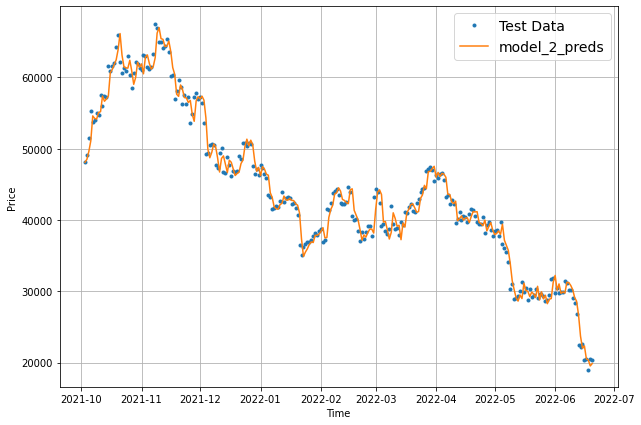

In [ ]:
offset = 300
plt.figure(figsize=(10,7))
plot_time_series(timesteps = X_test[-len(test_windows):], values = test_labels[:, 0], start = offset,label = "Test Data")
plot_time_series(timesteps = X_test[-len(test_windows):], values = model_2_preds, start = offset, format = '-', label = 'model_2_preds')

### Model 3: Dense Model (window = 30, horizon = 1)

In [ ]:
WINDOW_SIZE = 30
HORIZON = 7
full_windows, full_labels = make_windows(prices, window_size = WINDOW_SIZE, horizon = HORIZON)
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(42)
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation = 'relu'),
  layers.Dense(HORIZON, activation = 'linear')
], name = 'model_3')

model_3.compile(loss = "mae", 
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['mae', 'mse'])

model_3.fit(x = train_windows,y = train_labels, 
            epochs = 100, 
            verbose = 0, 
            batch_size = 100, 
            validation_data = (test_windows, test_labels), 
            callbacks = [create_model_checkpoint(model_name = model_3.name)])

INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


INFO:tensorflow:Assets written to: model_experiments/model_3/assets


In [ ]:
model_3 = tf.keras.models.load_model('/content/model_experiments/model_3')
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 2677.5637 - mae: 2677.5637 - mse: 13045047.0000


[2677.563720703125, 2677.563720703125, 13045047.0]

In [ ]:
model_3_preds = make_preds(model_3, test_windows)
model_3_results = evaluate_pred(y_true = tf.squeeze(test_labels), y_pred = model_3_preds)
model_3_results

{'mae': 2677.564,
 'mape': 6.4224863,
 'mase': 2.1370761,
 'mse': 13045047.0,
 'rmse': 3073.5884}

In [ ]:
naive_results

{'mae': 1245.2593,
 'mape': 2.9662337,
 'mase': 0.99879736,
 'mse': 2924243.8,
 'rmse': 1710.042}

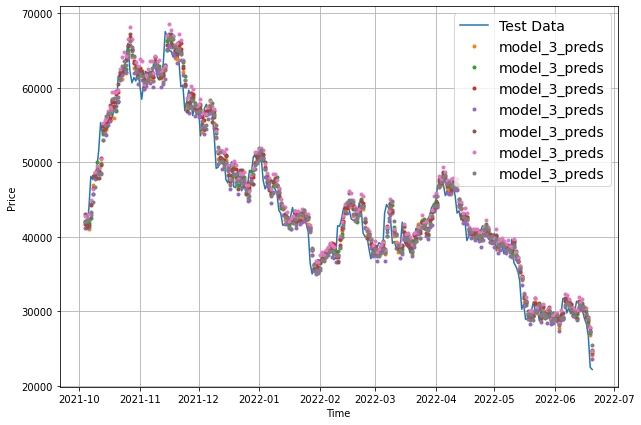

In [ ]:
offset = 300
plt.figure(figsize=(10,7))
plot_time_series(timesteps = X_test[-len(test_windows):], values = test_labels[:, 0], start = offset,format = '-', label = "Test Data")
plot_time_series(timesteps = X_test[-len(test_windows):], values = model_3_preds, start = offset, label = 'model_3_preds')

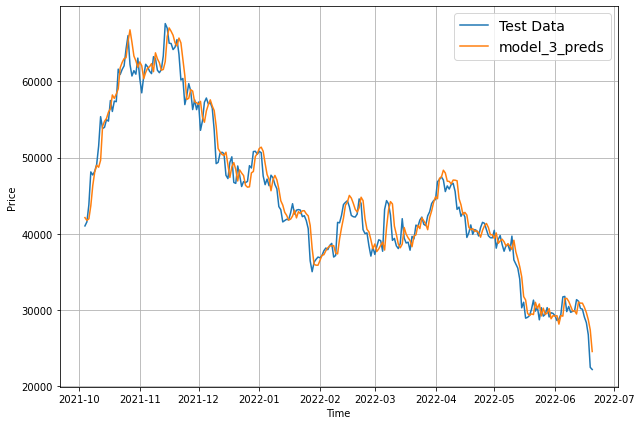

In [ ]:
offset = 300
plt.figure(figsize=(10,7))
plot_time_series(timesteps = X_test[-len(test_windows):], values = test_labels[:, 0], start = offset, format = '-' ,label = "Test Data")
plot_time_series(timesteps = X_test[-len(test_windows):], values = tf.reduce_mean(model_3_preds, axis = 1), start = offset, format = '-', label = 'model_3_preds')

### Comparing 3 models

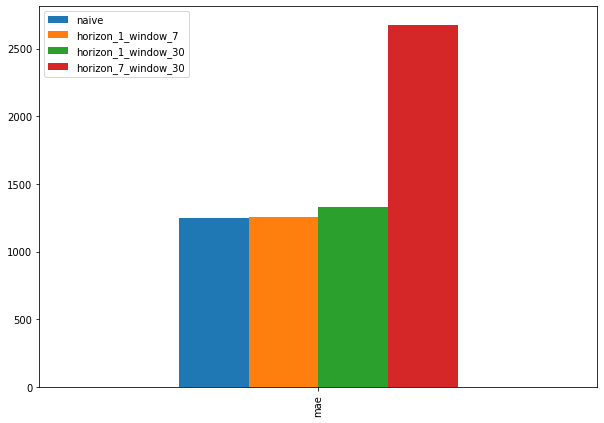

In [ ]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]}, index = ["mae"]).plot(figsize = (10, 7), kind = "bar")

### Model 4: Conv 1D

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
full_windows, full_labels = make_windows(prices, window_size = WINDOW_SIZE, horizon = HORIZON)
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

In [ ]:
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
       402.152008, 435.790985])>

In [ ]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))

In [ ]:
tf.random.set_seed(42)
model_4 = tf.keras.Sequential([
                               layers.Lambda(lambda x: tf.expand_dims(x, axis = 1)),
                               layers.Conv1D(filters = 128, kernel_size=5, strides=1, padding="causal", activation="relu"),
                               layers.Dense(HORIZON)
                               ], name = 'model_4')
model_4.compile(loss = 'mae', 
                optimizer = tf.keras.optimizers.Adam())
model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


INFO:tensorflow:Assets written to: model_experiments/model_4/assets


In [ ]:
model_4.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_4 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 128)            4608      
                                                                 
 dense_16 (Dense)            (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_4 = tf.keras.models.load_model('/content/model_experiments/model_4')
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 1258.8907


1258.8907470703125

In [ ]:
model_4_preds = make_preds(model_4, test_windows)
model_4_results = evaluate_pred(y_true = tf.squeeze(test_labels), y_pred = model_4_preds)
model_4_results

{'mae': 1258.8906,
 'mape': 3.0001152,
 'mase': 1.0097308,
 'mse': 2990960.5,
 'rmse': 1729.4393}

In [ ]:
naive_results

{'mae': 1245.2593,
 'mape': 2.9662337,
 'mase': 0.99879736,
 'mse': 2924243.8,
 'rmse': 1710.042}

### Model 5: RNN (LSTM)

In [ ]:
tf.random.set_seed(42)
inputs = layers.Input(shape = WINDOW_SIZE)
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
# x = layers.LSTM(128, return_sequences = True)(x)
x = layers.LSTM(128, activation="relu")(x)
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)  
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5")

model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
17/18 [===========================>..] - ETA: 0s - loss: 3515.6775INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 3s 123ms/step - loss: 3486.1484 - val_loss: 21352.9629
Epoch 2/100
 9/18 [==============>...............] - ETA: 0s - loss: 1842.8267INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 97ms/step - loss: 1290.7638 - val_loss: 2095.0837
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 335.3479 - val_loss: 2318.4106
Epoch 4/100
18/18 [==============================] - 0s 6ms/step - loss: 259.8101 - val_loss: 2273.4175
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 233.1584 - val_loss: 2147.1692
Epoch 6/100
10/18 [===============>..............] - ETA: 0s - loss: 216.9727INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 95ms/step - loss: 226.4470 - val_loss: 2063.5442
Epoch 7/100
11/18 [=================>............] - ETA: 0s - loss: 215.0922INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 94ms/step - loss: 224.1179 - val_loss: 2055.1267
Epoch 8/100
11/18 [=================>............] - ETA: 0s - loss: 221.8831INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 92ms/step - loss: 222.2966 - val_loss: 2042.9492
Epoch 9/100
11/18 [=================>............] - ETA: 0s - loss: 219.0190INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 120ms/step - loss: 221.0363 - val_loss: 2022.4492
Epoch 10/100
12/18 [===================>..........] - ETA: 0s - loss: 215.4776INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 98ms/step - loss: 219.3566 - val_loss: 2009.8174
Epoch 11/100
10/18 [===============>..............] - ETA: 0s - loss: 212.3758INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 98ms/step - loss: 217.3077 - val_loss: 1998.9159
Epoch 12/100
 9/18 [==============>...............] - ETA: 0s - loss: 219.6058INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 93ms/step - loss: 215.4791 - val_loss: 1970.4594
Epoch 13/100
12/18 [===================>..........] - ETA: 0s - loss: 216.0574INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 94ms/step - loss: 214.4364 - val_loss: 1957.0221
Epoch 14/100
12/18 [===================>..........] - ETA: 0s - loss: 209.2265INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 119ms/step - loss: 211.0884 - val_loss: 1949.6233
Epoch 15/100
11/18 [=================>............] - ETA: 0s - loss: 219.2557INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 94ms/step - loss: 209.0309 - val_loss: 1924.3101
Epoch 16/100
11/18 [=================>............] - ETA: 0s - loss: 208.5583INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 93ms/step - loss: 206.6241 - val_loss: 1896.9302
Epoch 17/100
11/18 [=================>............] - ETA: 0s - loss: 206.8737INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 94ms/step - loss: 205.9225 - val_loss: 1876.6763
Epoch 18/100
11/18 [=================>............] - ETA: 0s - loss: 207.3998INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 93ms/step - loss: 201.7734 - val_loss: 1816.2317
Epoch 19/100
18/18 [==============================] - 0s 7ms/step - loss: 203.3597 - val_loss: 1881.2372
Epoch 20/100
18/18 [==============================] - 0s 7ms/step - loss: 199.1019 - val_loss: 1838.0599
Epoch 21/100
18/18 [==============================] - 0s 7ms/step - loss: 197.7135 - val_loss: 1940.8013
Epoch 22/100
18/18 [==============================] - 0s 7ms/step - loss: 204.0842 - val_loss: 1838.7607
Epoch 23/100
18/18 [==============================] - 0s 6ms/step - loss: 198.8221 - val_loss: 1818.8574
Epoch 24/100
18/18 [==============================] - 0s 7ms/step - loss: 195.4692 - val_loss: 1825.3156
Epoch 25/100
11/18 [=================>............] - ETA: 0s - loss: 202.8112INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 119ms/step - loss: 195.2404 - val_loss: 1780.5995
Epoch 26/100
18/18 [==============================] - 0s 7ms/step - loss: 192.4290 - val_loss: 1788.1938
Epoch 27/100
11/18 [=================>............] - ETA: 0s - loss: 180.6750INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 94ms/step - loss: 189.7143 - val_loss: 1779.5696
Epoch 28/100
 9/18 [==============>...............] - ETA: 0s - loss: 181.3043INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 94ms/step - loss: 188.4214 - val_loss: 1724.8428
Epoch 29/100
12/18 [===================>..........] - ETA: 0s - loss: 183.3027INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 95ms/step - loss: 185.1866 - val_loss: 1720.3513
Epoch 30/100
12/18 [===================>..........] - ETA: 0s - loss: 180.6977INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 117ms/step - loss: 182.7081 - val_loss: 1693.5607
Epoch 31/100
12/18 [===================>..........] - ETA: 0s - loss: 181.9719INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 95ms/step - loss: 181.9340 - val_loss: 1672.5562
Epoch 32/100
10/18 [===============>..............] - ETA: 0s - loss: 186.9041INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 97ms/step - loss: 178.9555 - val_loss: 1658.5557
Epoch 33/100
18/18 [==============================] - 0s 7ms/step - loss: 177.1689 - val_loss: 1661.1982
Epoch 34/100
11/18 [=================>............] - ETA: 0s - loss: 185.7052INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 94ms/step - loss: 175.8784 - val_loss: 1634.2228
Epoch 35/100
18/18 [==============================] - ETA: 0s - loss: 173.8671INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 99ms/step - loss: 173.8671 - val_loss: 1616.2051
Epoch 36/100
11/18 [=================>............] - ETA: 0s - loss: 177.3208INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 120ms/step - loss: 170.1351 - val_loss: 1608.2825
Epoch 37/100
 9/18 [==============>...............] - ETA: 0s - loss: 166.7070INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 95ms/step - loss: 169.0743 - val_loss: 1576.5797
Epoch 38/100
11/18 [=================>............] - ETA: 0s - loss: 175.7709INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 94ms/step - loss: 167.8157 - val_loss: 1561.5820
Epoch 39/100
11/18 [=================>............] - ETA: 0s - loss: 172.3273INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 93ms/step - loss: 165.7959 - val_loss: 1558.0690
Epoch 40/100
12/18 [===================>..........] - ETA: 0s - loss: 169.9626INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 93ms/step - loss: 165.0576 - val_loss: 1530.6547
Epoch 41/100
18/18 [==============================] - 0s 6ms/step - loss: 162.3635 - val_loss: 1530.8026
Epoch 42/100
11/18 [=================>............] - ETA: 0s - loss: 158.4138INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 119ms/step - loss: 164.5997 - val_loss: 1513.0499
Epoch 43/100
18/18 [==============================] - 0s 6ms/step - loss: 161.7058 - val_loss: 1519.5701
Epoch 44/100
11/18 [=================>............] - ETA: 0s - loss: 160.0613INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 94ms/step - loss: 157.1849 - val_loss: 1498.6758
Epoch 45/100
16/18 [=========================>....] - ETA: 0s - loss: 159.1890INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 94ms/step - loss: 158.2991 - val_loss: 1482.2385
Epoch 46/100
12/18 [===================>..........] - ETA: 0s - loss: 157.1258INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 92ms/step - loss: 156.7435 - val_loss: 1464.4875
Epoch 47/100
12/18 [===================>..........] - ETA: 0s - loss: 160.3494INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 93ms/step - loss: 156.1210 - val_loss: 1456.9486
Epoch 48/100
11/18 [=================>............] - ETA: 0s - loss: 147.6325INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 118ms/step - loss: 153.7961 - val_loss: 1452.8810
Epoch 49/100
12/18 [===================>..........] - ETA: 0s - loss: 151.9792INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 94ms/step - loss: 154.4514 - val_loss: 1441.8142
Epoch 50/100
18/18 [==============================] - 0s 7ms/step - loss: 153.1025 - val_loss: 1470.4342
Epoch 51/100
18/18 [==============================] - 0s 6ms/step - loss: 154.6859 - val_loss: 1441.9716
Epoch 52/100
12/18 [===================>..........] - ETA: 0s - loss: 158.7254INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 95ms/step - loss: 153.8499 - val_loss: 1427.7413
Epoch 53/100
18/18 [==============================] - 0s 7ms/step - loss: 154.4394 - val_loss: 1460.8213
Epoch 54/100
18/18 [==============================] - 0s 6ms/step - loss: 152.9770 - val_loss: 1492.7737
Epoch 55/100
11/18 [=================>............] - ETA: 0s - loss: 152.2347INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 94ms/step - loss: 153.8896 - val_loss: 1415.8013
Epoch 56/100
11/18 [=================>............] - ETA: 0s - loss: 154.5464INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 117ms/step - loss: 151.5061 - val_loss: 1404.4458
Epoch 57/100
10/18 [===============>..............] - ETA: 0s - loss: 145.7894INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 97ms/step - loss: 148.1304 - val_loss: 1399.0450
Epoch 58/100
18/18 [==============================] - 0s 7ms/step - loss: 148.4640 - val_loss: 1455.3444
Epoch 59/100
18/18 [==============================] - 0s 7ms/step - loss: 153.3596 - val_loss: 1420.1184
Epoch 60/100
12/18 [===================>..........] - ETA: 0s - loss: 146.0597INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 98ms/step - loss: 148.9986 - val_loss: 1389.0931
Epoch 61/100
18/18 [==============================] - 0s 7ms/step - loss: 150.9072 - val_loss: 1438.3684
Epoch 62/100
11/18 [=================>............] - ETA: 0s - loss: 148.3578INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 96ms/step - loss: 148.1538 - val_loss: 1382.6603
Epoch 63/100
18/18 [==============================] - 0s 7ms/step - loss: 147.1079 - val_loss: 1440.6873
Epoch 64/100
18/18 [==============================] - 0s 7ms/step - loss: 149.6970 - val_loss: 1392.8547
Epoch 65/100
12/18 [===================>..........] - ETA: 0s - loss: 148.5066INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 93ms/step - loss: 147.1522 - val_loss: 1380.1470
Epoch 66/100
11/18 [=================>............] - ETA: 0s - loss: 142.6892INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 119ms/step - loss: 146.0709 - val_loss: 1373.4487
Epoch 67/100
18/18 [==============================] - 0s 7ms/step - loss: 147.4711 - val_loss: 1419.7244
Epoch 68/100
18/18 [==============================] - 0s 6ms/step - loss: 152.4327 - val_loss: 1447.3231
Epoch 69/100
11/18 [=================>............] - ETA: 0s - loss: 150.6734INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 95ms/step - loss: 147.1360 - val_loss: 1366.5833
Epoch 70/100
18/18 [==============================] - 0s 7ms/step - loss: 145.7164 - val_loss: 1395.5493
Epoch 71/100
18/18 [==============================] - 0s 7ms/step - loss: 149.1620 - val_loss: 1382.3910
Epoch 72/100
18/18 [==============================] - 0s 7ms/step - loss: 147.3647 - val_loss: 1391.2646
Epoch 73/100
12/18 [===================>..........] - ETA: 0s - loss: 150.5565INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 93ms/step - loss: 145.7243 - val_loss: 1358.9349
Epoch 74/100
11/18 [=================>............] - ETA: 0s - loss: 142.2515INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 92ms/step - loss: 143.4212 - val_loss: 1358.6570
Epoch 75/100
11/18 [=================>............] - ETA: 0s - loss: 140.4861INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 95ms/step - loss: 143.0744 - val_loss: 1356.7894
Epoch 76/100
18/18 [==============================] - 0s 7ms/step - loss: 145.6058 - val_loss: 1361.7267
Epoch 77/100
18/18 [==============================] - 0s 7ms/step - loss: 145.6917 - val_loss: 1372.7405
Epoch 78/100
18/18 [==============================] - 0s 7ms/step - loss: 149.8410 - val_loss: 1387.3370
Epoch 79/100
11/18 [=================>............] - ETA: 0s - loss: 136.8039INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 120ms/step - loss: 144.2447 - val_loss: 1352.9442
Epoch 80/100
18/18 [==============================] - 0s 7ms/step - loss: 142.7352 - val_loss: 1356.3832
Epoch 81/100
12/18 [===================>..........] - ETA: 0s - loss: 146.6541INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 92ms/step - loss: 143.1857 - val_loss: 1346.5677
Epoch 82/100
18/18 [==============================] - 0s 7ms/step - loss: 142.4135 - val_loss: 1351.8716
Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 145.8804 - val_loss: 1437.7028
Epoch 84/100
12/18 [===================>..........] - ETA: 0s - loss: 150.8514INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 95ms/step - loss: 144.3708 - val_loss: 1345.1592
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 142.0164 - val_loss: 1349.8584
Epoch 86/100
 9/18 [==============>...............] - ETA: 0s - loss: 136.8818INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 98ms/step - loss: 142.9797 - val_loss: 1343.9000
Epoch 87/100
11/18 [=================>............] - ETA: 0s - loss: 143.5284INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 92ms/step - loss: 145.6912 - val_loss: 1338.4999
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 143.2408 - val_loss: 1355.8940
Epoch 89/100
10/18 [===============>..............] - ETA: 0s - loss: 137.2004INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 121ms/step - loss: 141.3392 - val_loss: 1335.5531
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 141.8488 - val_loss: 1347.0747
Epoch 91/100
11/18 [=================>............] - ETA: 0s - loss: 146.4722INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 98ms/step - loss: 144.3659 - val_loss: 1333.9255
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 141.5341 - val_loss: 1378.3750
Epoch 93/100
18/18 [==============================] - 0s 6ms/step - loss: 142.0372 - val_loss: 1355.1730
Epoch 94/100
18/18 [==============================] - 0s 6ms/step - loss: 146.0904 - val_loss: 1380.3328
Epoch 95/100
11/18 [=================>............] - ETA: 0s - loss: 146.9569INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 95ms/step - loss: 142.4818 - val_loss: 1332.6272
Epoch 96/100
18/18 [==============================] - 0s 7ms/step - loss: 143.9374 - val_loss: 1353.4369
Epoch 97/100
18/18 [==============================] - 0s 7ms/step - loss: 143.4921 - val_loss: 1369.3156
Epoch 98/100
18/18 [==============================] - 0s 7ms/step - loss: 147.3914 - val_loss: 1478.9640
Epoch 99/100
11/18 [=================>............] - ETA: 0s - loss: 149.1191INFO:tensorflow:Assets written to: model_experiments/model_5/assets


INFO:tensorflow:Assets written to: model_experiments/model_5/assets


18/18 [==============================] - 2s 93ms/step - loss: 149.0950 - val_loss: 1323.7534
Epoch 100/100
18/18 [==============================] - 0s 8ms/step - loss: 142.6977 - val_loss: 1351.5515


In [ ]:
model_5 = tf.keras.models.load_model('/content/model_experiments/model_5')
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1323.7533


1323.7532958984375

In [ ]:
model_5_preds = make_preds(model_5, test_windows)
model_5_results = evaluate_pred(y_true = tf.squeeze(test_labels), y_pred = model_5_preds)
model_5_results

{'mae': 1323.7534,
 'mape': 3.1562712,
 'mase': 1.0617559,
 'mse': 3184392.2,
 'rmse': 1784.4865}

### Model 6: Multivariate time series

In [ ]:
block_reward_1=50
block_reward_2=25
block_reward_3=12.5
block_reward_4=6.25

block_reward_2_datatime = np.datetime64("2012-11-28")
block_reward_3_datatime = np.datetime64("2016-07-09")
block_reward_4_datatime = np.datetime64("2020-05-18")

In [ ]:
block_reward_2_days = (block_reward_3_datatime - stock_prices.index[0]).days
block_reward_3_days = (block_reward_4_datatime - stock_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(661, 2070)

In [ ]:
stock_prices_block = stock_prices.copy()
stock_prices_block["block_reward"] = None
stock_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
stock_prices_block.iloc[:block_reward_3_days, -1] = block_reward_3
stock_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4

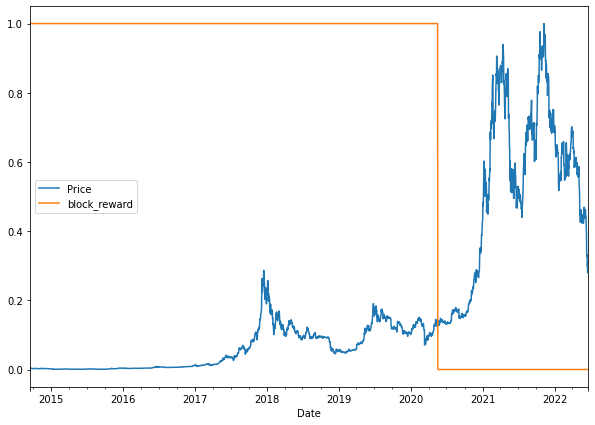

In [ ]:
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(stock_prices_block[["Price", "block_reward"]]),
                                     columns= stock_prices_block.columns,
                                     index=stock_prices_block.index)
scaled_price_block_df.plot(figsize=(10,7))

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
stock_prices_windowed = stock_prices_block.copy()
for i in range(WINDOW_SIZE):
  stock_prices_windowed[f"Price+{i+1}"] = stock_prices_windowed["Price"].shift(periods=i+1)
stock_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2014-09-17,457.334015,12.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,424.440002,12.5,457.334015,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-19,394.795990,12.5,424.440002,457.334015,NaN,NaN,NaN,NaN,NaN
2014-09-20,408.903992,12.5,394.795990,424.440002,457.334015,NaN,NaN,NaN,NaN
2014-09-21,398.821014,12.5,408.903992,394.795990,424.440002,457.334015,NaN,NaN,NaN
2014-09-22,402.152008,12.5,398.821014,408.903992,394.795990,424.440002,457.334015,NaN,NaN
2014-09-23,435.790985,12.5,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015,NaN
2014-09-24,423.204987,12.5,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-25,411.574005,12.5,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002


In [ ]:
X = stock_prices_windowed.dropna().drop("Price", axis = 1).astype(np.float32)
y = stock_prices_windowed.dropna()["Price"].astype(np.float32)

In [ ]:
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

In [ ]:
tf.random.set_seed(42)
model_6 = tf.keras.Sequential([
                               layers.Dense(128, activation = 'relu'),
                              #  layers.Dense(128, activation = 'relu'),
                               layers.Dense(HORIZON)],
                              name = 'model_6')
model_6.compile(loss = 'mae',
                optimizer = tf.keras.optimizers.Adam())
model_6.fit(X_train, y_train,
            epochs = 100,
            batch_size = 128,
            verbose = 1,
            validation_data =(X_test, y_test),
            callbacks = [create_model_checkpoint(model_name=model_6.name)])

Epoch 1/100
 1/18 [>.............................] - ETA: 5s - loss: 3576.2332INFO:tensorflow:Assets written to: model_experiments/model_6/assets


INFO:tensorflow:Assets written to: model_experiments/model_6/assets


18/18 [==============================] - 1s 29ms/step - loss: 1807.8865 - val_loss: 5039.8447
Epoch 2/100
 1/18 [>.............................] - ETA: 0s - loss: 593.1755INFO:tensorflow:Assets written to: model_experiments/model_6/assets


INFO:tensorflow:Assets written to: model_experiments/model_6/assets


18/18 [==============================] - 0s 24ms/step - loss: 455.4636 - val_loss: 2991.8716
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 329.6542INFO:tensorflow:Assets written to: model_experiments/model_6/assets


INFO:tensorflow:Assets written to: model_experiments/model_6/assets


18/18 [==============================] - 0s 24ms/step - loss: 287.7888 - val_loss: 2477.8042
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 248.4337INFO:tensorflow:Assets written to: model_experiments/model_6/assets


INFO:tensorflow:Assets written to: model_experiments/model_6/assets


18/18 [==============================] - 0s 25ms/step - loss: 266.4838 - val_loss: 2342.5889
Epoch 5/100
 1/18 [>.............................] - ETA: 0s - loss: 229.7468INFO:tensorflow:Assets written to: model_experiments/model_6/assets


INFO:tensorflow:Assets written to: model_experiments/model_6/assets


18/18 [==============================] - 0s 24ms/step - loss: 257.3104 - val_loss: 2318.6470
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 219.4404INFO:tensorflow:Assets written to: model_experiments/model_6/assets


INFO:tensorflow:Assets written to: model_experiments/model_6/assets


18/18 [==============================] - 0s 24ms/step - loss: 250.9969 - val_loss: 2254.8044
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 227.4438INFO:tensorflow:Assets written to: model_experiments/model_6/assets


INFO:tensorflow:Assets written to: model_experiments/model_6/assets


18/18 [==============================] - 0s 24ms/step - loss: 247.6007 - val_loss: 2247.7705
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 274.3088INFO:tensorflow:Assets written to: model_experiments/model_6/assets


INFO:tensorflow:Assets written to: model_experiments/model_6/assets


18/18 [==============================] - 0s 24ms/step - loss: 242.2227 - val_loss: 2158.8669
Epoch 9/100
 1/18 [>.............................] - ETA: 0s - loss: 282.8738INFO:tensorflow:Assets written to: model_experiments/model_6/assets


INFO:tensorflow:Assets written to: model_experiments/model_6/assets


18/18 [==============================] - 0s 25ms/step - loss: 238.0818 - val_loss: 2125.6230
Epoch 10/100
18/18 [==============================] - 0s 5ms/step - loss: 232.1719 - val_loss: 2142.2551
Epoch 11/100
 1/18 [>.............................] - ETA: 0s - loss: 205.1754INFO:tensorflow:Assets written to: model_experiments/model_6/assets


INFO:tensorflow:Assets written to: model_experiments/model_6/assets


18/18 [==============================] - 0s 24ms/step - loss: 223.8107 - val_loss: 2055.4871
Epoch 12/100
 1/18 [>.............................] - ETA: 0s - loss: 254.2300INFO:tensorflow:Assets written to: model_experiments/model_6/assets


INFO:tensorflow:Assets written to: model_experiments/model_6/assets


18/18 [==============================] - 0s 24ms/step - loss: 215.6228 - val_loss: 1988.2664
Epoch 13/100
 1/18 [>.............................] - ETA: 0s - loss: 217.4636INFO:tensorflow:Assets written to: model_experiments/model_6/assets


INFO:tensorflow:Assets written to: model_experiments/model_6/assets


18/18 [==============================] - 0s 24ms/step - loss: 210.7443 - val_loss: 1933.6765
Epoch 14/100
18/18 [==============================] - ETA: 0s - loss: 206.5982INFO:tensorflow:Assets written to: model_experiments/model_6/assets


INFO:tensorflow:Assets written to: model_experiments/model_6/assets


18/18 [==============================] - 0s 25ms/step - loss: 206.5982 - val_loss: 1862.7191
Epoch 15/100
 1/18 [>.............................] - ETA: 0s - loss: 191.3439INFO:tensorflow:Assets written to: model_experiments/model_6/assets


INFO:tensorflow:Assets written to: model_experiments/model_6/assets


18/18 [==============================] - 0s 24ms/step - loss: 195.1389 - val_loss: 1772.6287
Epoch 16/100
 1/18 [>.............................] - ETA: 0s - loss: 193.1746INFO:tensorflow:Assets written to: model_experiments/model_6/assets


INFO:tensorflow:Assets written to: model_experiments/model_6/assets


18/18 [==============================] - 0s 24ms/step - loss: 190.6416 - val_loss: 1737.8960
Epoch 17/100
 1/18 [>.............................] - ETA: 0s - loss: 149.9072INFO:tensorflow:Assets written to: model_experiments/model_6/assets


INFO:tensorflow:Assets written to: model_experiments/model_6/assets


18/18 [==============================] - 0s 24ms/step - loss: 196.5366 - val_loss: 1695.9508
Epoch 18/100
 1/18 [>.............................] - ETA: 0s - loss: 181.2296INFO:tensorflow:Assets written to: model_experiments/model_6/assets


INFO:tensorflow:Assets written to: model_experiments/model_6/assets


18/18 [==============================] - 0s 25ms/step - loss: 178.4834 - val_loss: 1636.0988
Epoch 19/100
 1/18 [>.............................] - ETA: 0s - loss: 159.3227INFO:tensorflow:Assets written to: model_experiments/model_6/assets


INFO:tensorflow:Assets written to: model_experiments/model_6/assets


18/18 [==============================] - 0s 25ms/step - loss: 174.2377 - val_loss: 1600.8171
Epoch 20/100
 1/18 [>.............................] - ETA: 0s - loss: 122.8761INFO:tensorflow:Assets written to: model_experiments/model_6/assets


INFO:tensorflow:Assets written to: model_experiments/model_6/assets


18/18 [==============================] - 0s 24ms/step - loss: 170.5252 - val_loss: 1574.2811
Epoch 21/100
18/18 [==============================] - 0s 4ms/step - loss: 169.3884 - val_loss: 1675.7396
Epoch 22/100
 1/18 [>.............................] - ETA: 0s - loss: 198.6399INFO:tensorflow:Assets written to: model_experiments/model_6/assets


INFO:tensorflow:Assets written to: model_experiments/model_6/assets


18/18 [==============================] - 0s 24ms/step - loss: 171.9329 - val_loss: 1499.3170
Epoch 23/100
 1/18 [>.............................] - ETA: 0s - loss: 155.7073INFO:tensorflow:Assets written to: model_experiments/model_6/assets


INFO:tensorflow:Assets written to: model_experiments/model_6/assets


18/18 [==============================] - 0s 24ms/step - loss: 157.9524 - val_loss: 1446.7490
Epoch 24/100
18/18 [==============================] - 0s 5ms/step - loss: 156.4536 - val_loss: 1460.8536
Epoch 25/100
 1/18 [>.............................] - ETA: 0s - loss: 161.9687INFO:tensorflow:Assets written to: model_experiments/model_6/assets


INFO:tensorflow:Assets written to: model_experiments/model_6/assets


18/18 [==============================] - 0s 25ms/step - loss: 152.7616 - val_loss: 1427.4839
Epoch 26/100
 1/18 [>.............................] - ETA: 0s - loss: 182.2266INFO:tensorflow:Assets written to: model_experiments/model_6/assets


INFO:tensorflow:Assets written to: model_experiments/model_6/assets


18/18 [==============================] - 0s 24ms/step - loss: 152.9496 - val_loss: 1399.0985
Epoch 27/100
18/18 [==============================] - 0s 5ms/step - loss: 153.4611 - val_loss: 1446.0024
Epoch 28/100
 1/18 [>.............................] - ETA: 0s - loss: 192.2096INFO:tensorflow:Assets written to: model_experiments/model_6/assets


INFO:tensorflow:Assets written to: model_experiments/model_6/assets


18/18 [==============================] - 1s 44ms/step - loss: 152.4043 - val_loss: 1393.8367
Epoch 29/100
 1/18 [>.............................] - ETA: 0s - loss: 131.3032INFO:tensorflow:Assets written to: model_experiments/model_6/assets


INFO:tensorflow:Assets written to: model_experiments/model_6/assets


18/18 [==============================] - 0s 25ms/step - loss: 150.9406 - val_loss: 1369.2898
Epoch 30/100
 1/18 [>.............................] - ETA: 0s - loss: 128.6837INFO:tensorflow:Assets written to: model_experiments/model_6/assets


INFO:tensorflow:Assets written to: model_experiments/model_6/assets


18/18 [==============================] - 0s 24ms/step - loss: 146.6144 - val_loss: 1369.0404
Epoch 31/100
 1/18 [>.............................] - ETA: 0s - loss: 94.9579INFO:tensorflow:Assets written to: model_experiments/model_6/assets


INFO:tensorflow:Assets written to: model_experiments/model_6/assets


18/18 [==============================] - 0s 24ms/step - loss: 147.0955 - val_loss: 1352.0681
Epoch 32/100
 1/18 [>.............................] - ETA: 0s - loss: 145.8807INFO:tensorflow:Assets written to: model_experiments/model_6/assets


INFO:tensorflow:Assets written to: model_experiments/model_6/assets


18/18 [==============================] - 0s 24ms/step - loss: 144.9013 - val_loss: 1348.2583
Epoch 33/100
18/18 [==============================] - 0s 5ms/step - loss: 145.7190 - val_loss: 1357.5479
Epoch 34/100
18/18 [==============================] - 0s 4ms/step - loss: 148.5461 - val_loss: 1363.2855
Epoch 35/100
 1/18 [>.............................] - ETA: 0s - loss: 122.8622INFO:tensorflow:Assets written to: model_experiments/model_6/assets


INFO:tensorflow:Assets written to: model_experiments/model_6/assets


18/18 [==============================] - 0s 25ms/step - loss: 145.3613 - val_loss: 1328.6072
Epoch 36/100
18/18 [==============================] - 0s 5ms/step - loss: 143.5804 - val_loss: 1332.4579
Epoch 37/100
 1/18 [>.............................] - ETA: 0s - loss: 150.3712INFO:tensorflow:Assets written to: model_experiments/model_6/assets


INFO:tensorflow:Assets written to: model_experiments/model_6/assets


18/18 [==============================] - 0s 24ms/step - loss: 141.9246 - val_loss: 1322.8013
Epoch 38/100
18/18 [==============================] - 0s 4ms/step - loss: 140.6361 - val_loss: 1326.3245
Epoch 39/100
18/18 [==============================] - 0s 4ms/step - loss: 144.5198 - val_loss: 1411.5087
Epoch 40/100
18/18 [==============================] - 0s 4ms/step - loss: 147.7219 - val_loss: 1346.8262
Epoch 41/100
18/18 [==============================] - 0s 4ms/step - loss: 143.4592 - val_loss: 1425.6852
Epoch 42/100
18/18 [==============================] - 0s 4ms/step - loss: 151.4545 - val_loss: 1366.9971
Epoch 43/100
18/18 [==============================] - 0s 4ms/step - loss: 145.5223 - val_loss: 1325.9346
Epoch 44/100
 1/18 [>.............................] - ETA: 0s - loss: 165.0111INFO:tensorflow:Assets written to: model_experiments/model_6/assets


INFO:tensorflow:Assets written to: model_experiments/model_6/assets


18/18 [==============================] - 0s 25ms/step - loss: 144.7067 - val_loss: 1295.9330
Epoch 45/100
18/18 [==============================] - 0s 4ms/step - loss: 137.9846 - val_loss: 1314.9027
Epoch 46/100
18/18 [==============================] - 0s 4ms/step - loss: 137.1104 - val_loss: 1321.1595
Epoch 47/100
18/18 [==============================] - 0s 4ms/step - loss: 145.1701 - val_loss: 1369.3837
Epoch 48/100
18/18 [==============================] - 0s 4ms/step - loss: 153.3858 - val_loss: 1385.5747
Epoch 49/100
 1/18 [>.............................] - ETA: 0s - loss: 144.4686INFO:tensorflow:Assets written to: model_experiments/model_6/assets


INFO:tensorflow:Assets written to: model_experiments/model_6/assets


18/18 [==============================] - 0s 25ms/step - loss: 144.3545 - val_loss: 1291.5598
Epoch 50/100
18/18 [==============================] - 0s 4ms/step - loss: 140.6205 - val_loss: 1345.0605
Epoch 51/100
18/18 [==============================] - 0s 4ms/step - loss: 150.4033 - val_loss: 1575.7366
Epoch 52/100
18/18 [==============================] - 0s 4ms/step - loss: 140.5776 - val_loss: 1316.2300
Epoch 53/100
 1/18 [>.............................] - ETA: 0s - loss: 138.9860INFO:tensorflow:Assets written to: model_experiments/model_6/assets


INFO:tensorflow:Assets written to: model_experiments/model_6/assets


18/18 [==============================] - 0s 24ms/step - loss: 137.0717 - val_loss: 1288.2937
Epoch 54/100
18/18 [==============================] - 0s 4ms/step - loss: 136.6962 - val_loss: 1355.0405
Epoch 55/100
 1/18 [>.............................] - ETA: 0s - loss: 145.7659INFO:tensorflow:Assets written to: model_experiments/model_6/assets


INFO:tensorflow:Assets written to: model_experiments/model_6/assets


18/18 [==============================] - 0s 25ms/step - loss: 140.4077 - val_loss: 1274.2316
Epoch 56/100
18/18 [==============================] - 0s 4ms/step - loss: 137.8033 - val_loss: 1294.7142
Epoch 57/100
18/18 [==============================] - 0s 4ms/step - loss: 137.3008 - val_loss: 1322.7719
Epoch 58/100
18/18 [==============================] - 0s 4ms/step - loss: 139.6652 - val_loss: 1277.6881
Epoch 59/100
 1/18 [>.............................] - ETA: 0s - loss: 122.9572INFO:tensorflow:Assets written to: model_experiments/model_6/assets


INFO:tensorflow:Assets written to: model_experiments/model_6/assets


18/18 [==============================] - 0s 26ms/step - loss: 136.0802 - val_loss: 1270.6852
Epoch 60/100
18/18 [==============================] - 0s 4ms/step - loss: 139.4220 - val_loss: 1329.3508
Epoch 61/100
18/18 [==============================] - 0s 4ms/step - loss: 137.4690 - val_loss: 1458.7089
Epoch 62/100
18/18 [==============================] - 0s 4ms/step - loss: 141.3302 - val_loss: 1281.3214
Epoch 63/100
18/18 [==============================] - 0s 3ms/step - loss: 138.3835 - val_loss: 1280.2947
Epoch 64/100
18/18 [==============================] - 0s 5ms/step - loss: 138.5459 - val_loss: 1281.3361
Epoch 65/100
18/18 [==============================] - 0s 4ms/step - loss: 136.4041 - val_loss: 1273.1996
Epoch 66/100
18/18 [==============================] - 0s 4ms/step - loss: 138.2420 - val_loss: 1288.9354
Epoch 67/100
18/18 [==============================] - 0s 4ms/step - loss: 136.2428 - val_loss: 1320.0055
Epoch 68/100
18/18 [==============================] - 0s 4ms/step -

INFO:tensorflow:Assets written to: model_experiments/model_6/assets


18/18 [==============================] - 0s 24ms/step - loss: 137.4942 - val_loss: 1262.3767
Epoch 70/100
18/18 [==============================] - 0s 4ms/step - loss: 136.5372 - val_loss: 1372.8420
Epoch 71/100
18/18 [==============================] - 0s 4ms/step - loss: 139.1927 - val_loss: 1304.9709
Epoch 72/100
 1/18 [>.............................] - ETA: 0s - loss: 108.5765INFO:tensorflow:Assets written to: model_experiments/model_6/assets


INFO:tensorflow:Assets written to: model_experiments/model_6/assets


18/18 [==============================] - 0s 24ms/step - loss: 136.7597 - val_loss: 1260.6406
Epoch 73/100
18/18 [==============================] - 0s 4ms/step - loss: 144.2542 - val_loss: 1273.4856
Epoch 74/100
18/18 [==============================] - 0s 4ms/step - loss: 138.6799 - val_loss: 1386.0674
Epoch 75/100
 1/18 [>.............................] - ETA: 0s - loss: 119.4414INFO:tensorflow:Assets written to: model_experiments/model_6/assets


INFO:tensorflow:Assets written to: model_experiments/model_6/assets


18/18 [==============================] - 0s 24ms/step - loss: 138.1987 - val_loss: 1259.4646
Epoch 76/100
18/18 [==============================] - 0s 4ms/step - loss: 139.9239 - val_loss: 1272.2762
Epoch 77/100
18/18 [==============================] - 0s 4ms/step - loss: 137.3628 - val_loss: 1268.3594
Epoch 78/100
18/18 [==============================] - 0s 4ms/step - loss: 136.5196 - val_loss: 1264.9353
Epoch 79/100
18/18 [==============================] - 0s 4ms/step - loss: 135.6756 - val_loss: 1263.1520
Epoch 80/100
18/18 [==============================] - 0s 4ms/step - loss: 133.7659 - val_loss: 1262.2207
Epoch 81/100
18/18 [==============================] - 0s 4ms/step - loss: 137.3204 - val_loss: 1422.3542
Epoch 82/100
 1/18 [>.............................] - ETA: 0s - loss: 151.6910INFO:tensorflow:Assets written to: model_experiments/model_6/assets


INFO:tensorflow:Assets written to: model_experiments/model_6/assets


18/18 [==============================] - 0s 25ms/step - loss: 137.5266 - val_loss: 1258.4553
Epoch 83/100
18/18 [==============================] - 0s 4ms/step - loss: 133.8627 - val_loss: 1333.0704
Epoch 84/100
 1/18 [>.............................] - ETA: 0s - loss: 157.1290INFO:tensorflow:Assets written to: model_experiments/model_6/assets


INFO:tensorflow:Assets written to: model_experiments/model_6/assets


18/18 [==============================] - 0s 25ms/step - loss: 136.6839 - val_loss: 1256.8369
Epoch 85/100
18/18 [==============================] - 0s 4ms/step - loss: 134.7097 - val_loss: 1301.3141
Epoch 86/100
18/18 [==============================] - 0s 4ms/step - loss: 138.6127 - val_loss: 1265.2576
Epoch 87/100
 1/18 [>.............................] - ETA: 0s - loss: 117.5391INFO:tensorflow:Assets written to: model_experiments/model_6/assets


INFO:tensorflow:Assets written to: model_experiments/model_6/assets


18/18 [==============================] - 0s 24ms/step - loss: 137.1439 - val_loss: 1256.6063
Epoch 88/100
18/18 [==============================] - 0s 5ms/step - loss: 136.2092 - val_loss: 1311.6729
Epoch 89/100
18/18 [==============================] - 0s 4ms/step - loss: 136.2586 - val_loss: 1299.8898
Epoch 90/100
 1/18 [>.............................] - ETA: 0s - loss: 138.9311INFO:tensorflow:Assets written to: model_experiments/model_6/assets


INFO:tensorflow:Assets written to: model_experiments/model_6/assets


18/18 [==============================] - 0s 23ms/step - loss: 136.2416 - val_loss: 1256.0295
Epoch 91/100
18/18 [==============================] - 0s 4ms/step - loss: 138.3881 - val_loss: 1274.4618
Epoch 92/100
18/18 [==============================] - 0s 4ms/step - loss: 135.3884 - val_loss: 1276.8370
Epoch 93/100
18/18 [==============================] - 0s 4ms/step - loss: 137.9111 - val_loss: 1268.4960
Epoch 94/100
18/18 [==============================] - 0s 4ms/step - loss: 134.7191 - val_loss: 1264.3337
Epoch 95/100
 1/18 [>.............................] - ETA: 0s - loss: 131.6050INFO:tensorflow:Assets written to: model_experiments/model_6/assets


INFO:tensorflow:Assets written to: model_experiments/model_6/assets


18/18 [==============================] - 0s 24ms/step - loss: 133.8561 - val_loss: 1255.2227
Epoch 96/100
 1/18 [>.............................] - ETA: 0s - loss: 124.2827INFO:tensorflow:Assets written to: model_experiments/model_6/assets


INFO:tensorflow:Assets written to: model_experiments/model_6/assets


18/18 [==============================] - 0s 23ms/step - loss: 135.2373 - val_loss: 1255.1241
Epoch 97/100
18/18 [==============================] - 0s 4ms/step - loss: 134.6032 - val_loss: 1258.7753
Epoch 98/100
18/18 [==============================] - 0s 4ms/step - loss: 140.5407 - val_loss: 1348.4888
Epoch 99/100
 1/18 [>.............................] - ETA: 0s - loss: 169.9837INFO:tensorflow:Assets written to: model_experiments/model_6/assets


INFO:tensorflow:Assets written to: model_experiments/model_6/assets


18/18 [==============================] - 0s 24ms/step - loss: 135.0137 - val_loss: 1254.2714
Epoch 100/100
18/18 [==============================] - 0s 4ms/step - loss: 133.3243 - val_loss: 1254.5513


In [ ]:
model_6 = tf.keras.models.load_model('/content/model_experiments/model_6')
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 1254.2714


1254.2713623046875

In [ ]:
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([19006.842, 19162.17 , 19507.822, 18802.883, 19023.557, 19376.092,
       19177.12 , 18408.596, 18522.082, 18294.191], dtype=float32)>

In [ ]:
model_6_results = evaluate_pred(y_true = y_test, 
                                 y_pred = model_6_preds)
model_6_results

{'mae': 1254.2714,
 'mape': 2.986687,
 'mase': 1.0060258,
 'mse': 2952378.0,
 'rmse': 1718.2485}

In [ ]:
model_1_results

{'mae': 1251.7927,
 'mape': 2.9839077,
 'mase': 1.0040377,
 'mse': 2964340.0,
 'rmse': 1721.7258}

### Model 7: N-BEATS Algorithm

In [ ]:
class 